# Apply Developed model to traget data

In [254]:
import os
import pandas as pd
import numpy as np
import pickle
import sys
from pandas import HDFStore,DataFrame
from datetime import date, datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import yaml
import math
import xgboost

import matplotlib.pyplot as plt
import seaborn as sns
#from matplotlib_venn import venn2


cfg = None
    #' load config.yaml file in the root dir 
with open("../config.yaml", 'r') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

# Use 3 decimal places in output display
pd.set_option("display.precision", 3)

# Don't wrap repr(DataFrame) across additional lines
pd.set_option("display.expand_frame_repr", False)

# Set max rows displayed in output to 25
pd.set_option("display.max_rows", 25)

pd.set_option('display.float_format', lambda x: '%.2f' % x)

product_level = 'Product Level 2'

colors = ['#1F77B4', '#FF7F0E', 'orangered']

path_to_hdf_datastore = '../'+cfg['path_to_hdf_datastore']

NA_VALUES_LIST = ['Unassigned', 'Unknown','nan', 'N.A', 'N.A.', 'NaN', 'Nan', '00-00-00', '0-00-00']


In [255]:
# customer ids cols
ECH_ecrid_col = 'ecrid'
journals_ecrid_col = 'SIS Id  (Agreement SIS)'
other_ecrid_col = 'SIS Id  (Agreement SIS)'
churn_activities_ecrid_col = 'ECR Id'
churn_risks_ecrid_col = 'Account Name: ECR Id'
account_assignment_ecrid_col = 'ECRID'
NPS_ecrid_col = 'ECR_ID'
usage_ecrid_col = 'ECR_ID'
interactions_ecrid_col = 'ECR_ID'
cancellations_ecrid_col = 'SIS Id  (Agreement SIS)'

MERGE_ID = 'SIS Id  (Agreement SIS)'

In [256]:
def get_data_frame_summary(data_frame):
        unique_values = data_frame.apply(lambda x: [x.unique()])
        unique_counts = data_frame.apply(lambda x: len(x.unique()))
        na_counts = data_frame.apply(lambda x: sum(x.isna()))
        percent_missing = data_frame.apply(lambda x: sum(pd.isnull(x))/len(x)*100)
        data_type = data_frame.dtypes 

        return pd.DataFrame(dict(unique_values = unique_values, 
                                 unique_counts = unique_counts,
                                 na_counts = na_counts,
                                 data_type = data_type,
                                 percent_missing = percent_missing,
                                )).reset_index().sort_values(by='percent_missing', ascending=False)
    
# Function to scale features of numeric columns
def scale_numeric_features(data_frame, exclude=[], 
                           method='standardize',
                           inplace=False):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    num_cols = data_frame.select_dtypes(include=numerics).columns

    num_cols = num_cols.difference(exclude)
    print(f'********************* - Scaling following {len(num_cols)} features - **********************')
    for colname in num_cols:
        new_colname = colname if inplace else colname+'_'+method+'d'
        print(f' {colname} {method}d to {new_colname}')
        
        if method == 'standardize':              
              data_frame[new_colname] = (data_frame[colname] - data_frame[colname].mean()) / data_frame[colname].std()
        elif method == 'normalize':
              data_frame[new_colname] = (data_frame[colname] - data_frame[colname].min()) / (data_frame[colname].max() - data_frame[colname].min())
        else:
              print(f'Unknown method {method} specified, please select one of "standardize" or "normalize"')

      
    return data_frame


# number of agreements per ecr per product

def get_rfm_features_from_contracts(dataframe, groupcols):    

    dataframe = dataframe.groupby(
                groupcols
    ).agg(bookings=("Bookings - Final Net Price - Agent Discount Amount(Rep)", sum),
          mean_bookings = ("Bookings - Final Net Price - Agent Discount Amount(Rep)", 'mean'),
          num_agrmts=('Agreement Number', pd.Series.nunique), 
        num_agrmts_with_parent = ('Parent Agreement Number', pd.Series.nunique),
        last_agreement = ('Agreement Start Date', max),
        first_agreement = ('Agreement Start Date', min)
    ).sort_values('bookings', ascending=False)

    dataframe['last_agreement'] = pd.to_datetime(dataframe['last_agreement'], format='%Y-%m-%d')
    dataframe['first_agreement'] = pd.to_datetime(dataframe['first_agreement'], format='%Y-%m-%d')
    
    dataframe['days_since_last_agreement'] = dataframe['last_agreement'].apply(
        lambda x: (datetime.today() - x).days
        )
    dataframe['days_since_first_agreement'] = dataframe['first_agreement'].apply(
        lambda x: (datetime.today() - x).days
        )
    dataframe['length_of_relationship'] = (dataframe['days_since_first_agreement'] - 
                                           dataframe['days_since_last_agreement'])/365 
    dataframe['length_of_relationship'] = dataframe['length_of_relationship'].apply(math.ceil).clip(lower=1)
        
    dataframe['bookings_per_year'] = dataframe['bookings'] / dataframe['length_of_relationship']
    
    dataframe = dataframe.drop(['last_agreement', 'first_agreement'], axis=1)
    
    return dataframe


def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()
    
    
def encode_columns(df, columns_to_encode):
    for column in columns_to_encode:
        encoded_columns = pd.get_dummies(df[column])
        print(f'Encoding columns : {column} to {len(encoded_columns.columns)} new encoded columns')
        df = df.join(encoded_columns, rsuffix='_'+column).drop(column, axis=1)
    
    return df


# Function to drop outliers of numeric columns
def drop_outliers(data_frame, exclude=[], include=[]):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    num_cols = data_frame.select_dtypes(include=numerics).columns

    if len(include) > 0:
        num_cols = np.intersect1d(num_cols, include)
    elif len (exclude) > 0:
        num_cols = num_cols.difference(exclude)
    
    data_frame['DROP'] = False
    for colname in num_cols:
        upper_lim = data_frame[colname].quantile(.95)
        lower_lim = data_frame[colname].quantile(.05)
        
        print(f'Dropping outliers for {colname} upper limit = {upper_lim} and lower limit = {lower_lim}')
        #data_frame = data_frame[(data_frame[colname] < upper_lim) & (data_frame[colname] > lower_lim)]
        data_frame['DROP'] = data_frame['DROP'] | (data_frame[colname] > upper_lim) | (data_frame[colname] < lower_lim)
        
    
    data_frame = data_frame.loc[~data_frame['DROP']]
    print(f'Rows Remaining {data_frame.shape[0]}')
    data_frame = data_frame.drop(['DROP'], axis=1)    
    return data_frame


def get_trend_feature(df, new_colname, groupcols, timecols, prefix=''):
    SECOND_PERIOD = 1
    
    tempdf = df[groupcols + timecols]
    
    tempdf = tempdf.groupby(groupcols).sum()
    
    # increasing trend customers - - all customers with value True
    increasing_cust = (tempdf.diff(axis=1) > 0)[timecols[SECOND_PERIOD:]].apply(all, axis=1)
    increasing_cust_index = increasing_cust[increasing_cust].index
    
    print("INCREASING TREND")
    print(increasing_cust.value_counts())
    # decreasing trend customers - all customers with value False
    decreasing_cust = (tempdf.diff(axis=1) > 0)[timecols[SECOND_PERIOD:]].apply(any, axis=1)
    decreasing_cust_index = decreasing_cust[~decreasing_cust].index
    
    print("DECREASING TREND")
    print(decreasing_cust.value_counts())
    
    #df[new_colname] = 'updown_trend'
    df.loc[:,new_colname] = prefix+'updown_trend'
    df = df.set_index(groupcols)
    
    df.loc[increasing_cust_index, new_colname] = prefix+'increasing_trend'

    df.loc[decreasing_cust_index, new_colname] = prefix+'decreasing_trend'
    
    df = df.reset_index()
    
    return df


# Label Encoder

from sklearn import preprocessing

def encode_labels(df, cols_to_encode):
    
    le_dict = {}
    for col in cols_to_encode:
        le = preprocessing.LabelEncoder()
        le.fit(df[col])
        df[col] = le.transform(df[col])
        le_dict[col] = le
        
    return df, le_dict
        

def print_counts(df):
    print(df.shape)
    try:
        print(len(all_contracts_rfm['SIS Id  (Agreement SIS)'].unique()))
    except:
        print('No customer col')
    
    try:
        print(len(all_contracts_rfm["Product Line Level 2"].unique()))
    except:
        print('No Product col')
        
        
def print_counts(df, cust_id="SIS Id  (Agreement SIS)", prod_id="Product Line Level 2", group_by="TYPE"):
    print(f'Unique Customers : {len(df[cust_id].unique())}')
    print(f'Unique Products at Level 2 : {len(df[prod_id].unique())}')
    print(f'Unique Customer Product Combinations : {len(df[[cust_id, prod_id]].drop_duplicates())}')
    
    if group_by in df.columns:
        print(df.groupby([group_by]).agg(
        customers = (cust_id ,pd.Series.nunique), 
        products = (prod_id,pd.Series.nunique)))

### Read Contracts Data

In [257]:
all_contracts_dev = pd.read_pickle('../data/hdf/all_contracts_dev.pickle')
all_contracts_target = pd.read_pickle('../data/hdf/all_contracts_target.pickle')



In [258]:
all_contracts_target.groupby(['TYPE']).agg(
    customers = ("SIS Id  (Agreement SIS)" ,pd.Series.nunique), 
    products = ("Product Line Level 2",pd.Series.nunique))

,customers,products
TYPE,,
JOURNALS,5836,4
SOLUTIONS,5619,24


In [259]:
print_counts(all_contracts_target)

Unique Customers : 8642
Unique Products at Level 2 : 28
Unique Customer Product Combinations : 17474
           customers  products
TYPE                          
JOURNALS        5836         4
SOLUTIONS       5619        24


we will use customrs all contract history to compute RFM features, but keep on the the target customers for model application

In [260]:
all_contracts = pd.concat([all_contracts_dev, all_contracts_target])

In [261]:
active_value = all_contracts_target.groupby(["SIS Id  (Agreement SIS)", "Product Line Level 2"]).agg(
active_bookings = ('Bookings - Final Net Price - Agent Discount Amount(Rep)', sum)).reset_index()

In [262]:
active_value

,SIS Id (Agreement SIS),Product Line Level 2,active_bookings
0,ECR-1,Journal Level Sales,5310.11
1,ECR-1,Journals Backfiles,70787.25
2,ECR-1,Journals Electronic Subscriptions,938802.64
3,ECR-1,Knovel,165822.79
4,ECR-1,Reaxys,56000.00
...,...,...,...
17469,ECR-998,Journal Level Sales,26271.89
17470,ECR-998,Journals Electronic Subscriptions,1224866.74
17471,ECR-998,Knovel,74424.02
17472,ECR-998,Reaxys,36005.00


In [263]:
# Unique Customer x Product Level 2 Combinations

In [264]:
print(f'Unique Customers : {len(all_contracts["SIS Id  (Agreement SIS)"].unique())}')
print(f'Unique Products at Level 2 : {len(all_contracts["Product Line Level 2"].unique())}')
print(f'Unique Customer Product Combinations : {len(all_contracts[["SIS Id  (Agreement SIS)", "Product Line Level 2"]].drop_duplicates())}')

Unique Customers : 14604
Unique Products at Level 2 : 30
Unique Customer Product Combinations : 29366


### Total Bookings value over entire period

In [265]:
print(f' Total Bookings value all year in the data {all_contracts["Bookings - Final Net Price - Agent Discount Amount(Rep)"].sum()}')

 Total Bookings value all year in the data 11748059743.528244


### Total Bookings Value Spread over years

In [266]:
all_contracts.groupby(
    ['Subscription Start Year']
).agg(bookings=("Bookings - Final Net Price - Agent Discount Amount(Rep)", sum)
    ).sort_values('bookings', ascending=False).reset_index().sort_values(
    'Subscription Start Year').set_index('Subscription Start Year').T


Subscription Start Year,2015,2016,2017,2018,2019,2020,2021
bookings,1930629657.88,1945240938.66,1967744108.34,2056000119.08,1978285064.34,1870302299.62,-142444.40


## Load ECH and Hierarchy dataset

In [267]:
ech = pd.read_hdf(path_to_hdf_datastore, cfg['ech_hdf_file'])
hierarchy = pd.read_hdf(path_to_hdf_datastore, cfg['hierarchy_file'])

active_cust_hierarchy = pd.merge(ech[['ecrid', 'Classification']] , 
                                 hierarchy, left_on='ecrid', right_on='CHILD_ECR', how='inner')

active_cust_hierarchy = active_cust_hierarchy.drop(['ecrid', ], axis=1)

### calculate hierarchy features 

In [268]:
active_cust_hierarchy_agg = active_cust_hierarchy.groupby('PARENT_ECR').agg(
    num_child = ('CHILD_ECR', pd.Series.nunique),
    max_hier = ('HIER_LEVEL', max)
).sort_values('num_child', ascending=False)

In [269]:
active_cust_hierarchy_agg.head()

,num_child,max_hier
PARENT_ECR,,
ECR-10081512,4111,7
ECR-392273,4045,6
ECR-452899,3137,7
ECR-10002610,3094,7
ECR-334967,2169,6


In [270]:
active_cust_hierarchy = pd.merge(active_cust_hierarchy, active_cust_hierarchy_agg, 
                                 on='PARENT_ECR')

## Compute RFM (Recency , Frequency, Money) Variable from contracts data

In [271]:
all_contracts_rfm_cust = get_rfm_features_from_contracts(all_contracts, 
                                                         groupcols =['SIS Id  (Agreement SIS)', 'TYPE'])

In [272]:
all_contracts_rfm_cust = all_contracts_rfm_cust.rename(columns={"bookings": "total_bookings", 
                                       "mean_bookings": "total_mean_bookings",
                                       "num_agrmts": "total_num_agrmts",
                                       "num_agrmts_with_parent": "total_num_agrmts_with_parents",
                                       "days_since_last_agreement": "total_days_since_last_agreement",
                                       "days_since_first_agreement": "total_days_since_first_agreement",
                                       "length_of_relationship": "total_length_of_relationship",
                                       "bookings_per_year": "total_bookings_per_year"
                                      }).reset_index()

In [273]:
print(f'Unique Customers : {len(all_contracts_rfm_cust["SIS Id  (Agreement SIS)"].unique())}')

Unique Customers : 14604


In [274]:
all_contracts_rfm_cust.head()

,SIS Id (Agreement SIS),TYPE,total_bookings,total_mean_bookings,total_num_agrmts,total_num_agrmts_with_parents,total_days_since_last_agreement,total_days_since_first_agreement,total_length_of_relationship,total_bookings_per_year
0,ECR-490216,JOURNALS,540616150.45,63370.78,18,9,462,2288,6,90102691.74
1,ECR-310775,JOURNALS,212100864.34,10697.04,119,89,97,1923,6,35350144.06
2,ECR-71655,JOURNALS,105482309.24,4531.61,20,18,1192,1923,3,35160769.75
3,ECR-380603,JOURNALS,80971431.33,165585.75,31,30,281,1558,4,20242857.83
4,ECR-566584,JOURNALS,75711036.82,2365969.90,10,8,462,2653,7,10815862.40


In [275]:
all_contracts_rfm_cust['total_length_of_relationship'].unique()

array([ 6,  3,  4,  7,  5,  8,  1,  2,  9, 10, 11], dtype=int64)

## Calssify High Value Customers  / per year revenue

In [276]:
all_contracts_rfm_cust['over_million_year'] = all_contracts_rfm_cust['total_bookings_per_year'] > 1000000

In [277]:
all_contracts_rfm_cust['over_million_year'].value_counts()

False    18723
True       428
Name: over_million_year, dtype: int64

In [278]:
all_contracts_rfm_cust_prod = get_rfm_features_from_contracts(all_contracts, 
                                                         groupcols =['SIS Id  (Agreement SIS)', 'Product Line Level 2', 'TYPE'])

In [279]:
all_contracts_rfm_cust_prod = all_contracts_rfm_cust_prod.rename(columns={"bookings": "prod_bookings", 
                                       "mean_bookings": "prod_mean_bookings", 
                                       "num_agrmts": "prod_num_agrmts",
                                       "num_agrmts_with_parent": "prod_num_agrmts_with_parents",
                                       "days_since_last_agreement": "prod_days_since_last_agreement",
                                       "days_since_first_agreement": "prod_days_since_first_agreement",
                                       "length_of_relationship": "prod_length_of_relationship",
                                       "bookings_per_year": "prod_bookings_per_year"
                                      }).reset_index()

In [280]:
all_contracts_rfm_cust_prod.head()

,SIS Id (Agreement SIS),Product Line Level 2,TYPE,prod_bookings,prod_mean_bookings,prod_num_agrmts,prod_num_agrmts_with_parents,prod_days_since_last_agreement,prod_days_since_first_agreement,prod_length_of_relationship,prod_bookings_per_year
0,ECR-490216,Journals Electronic Subscriptions,JOURNALS,539714208.47,63780.93,18,9,462,2288,6,89952368.08
1,ECR-310775,Journals Electronic Subscriptions,JOURNALS,199378349.64,10419.02,94,73,97,1923,6,33229724.94
2,ECR-71655,Journals Electronic Subscriptions,JOURNALS,101988430.93,4604.03,20,18,1192,1923,3,33996143.64
3,ECR-380603,Journals Electronic Subscriptions,JOURNALS,79363274.73,1368332.32,21,20,281,1558,4,19840818.68
4,ECR-566584,Journals Electronic Subscriptions,JOURNALS,75711036.82,2365969.90,10,8,462,2653,7,10815862.40


In [281]:
all_contracts_rfm = pd.merge(all_contracts_rfm_cust, all_contracts_rfm_cust_prod, 
                             on=['SIS Id  (Agreement SIS)','TYPE'], how='inner')

In [282]:
all_contracts_rfm.columns

Index(['SIS Id  (Agreement SIS)', 'TYPE', 'total_bookings',
       'total_mean_bookings', 'total_num_agrmts',
       'total_num_agrmts_with_parents', 'total_days_since_last_agreement',
       'total_days_since_first_agreement', 'total_length_of_relationship',
       'total_bookings_per_year', 'over_million_year', 'Product Line Level 2',
       'prod_bookings', 'prod_mean_bookings', 'prod_num_agrmts',
       'prod_num_agrmts_with_parents', 'prod_days_since_last_agreement',
       'prod_days_since_first_agreement', 'prod_length_of_relationship',
       'prod_bookings_per_year'],
      dtype='object')

In [283]:
print(all_contracts_rfm_cust.shape)
print(all_contracts_rfm_cust_prod.shape)
print(all_contracts_rfm.shape)

print_counts(all_contracts_rfm)

(19151, 11)
(29366, 11)
(29366, 20)
Unique Customers : 14604
Unique Products at Level 2 : 30
Unique Customer Product Combinations : 29366
           customers  products
TYPE                          
JOURNALS       10359         5
SOLUTIONS       8792        25


In [284]:
del all_contracts_rfm_cust, all_contracts_rfm_cust_prod

In [285]:
all_contracts_rfm.head()

,SIS Id (Agreement SIS),TYPE,total_bookings,total_mean_bookings,total_num_agrmts,total_num_agrmts_with_parents,total_days_since_last_agreement,total_days_since_first_agreement,total_length_of_relationship,total_bookings_per_year,over_million_year,Product Line Level 2,prod_bookings,prod_mean_bookings,prod_num_agrmts,prod_num_agrmts_with_parents,prod_days_since_last_agreement,prod_days_since_first_agreement,prod_length_of_relationship,prod_bookings_per_year
0,ECR-490216,JOURNALS,540616150.45,63370.78,18,9,462,2288,6,90102691.74,True,Journals Electronic Subscriptions,539714208.47,63780.93,18,9,462,2288,6,89952368.08
1,ECR-490216,JOURNALS,540616150.45,63370.78,18,9,462,2288,6,90102691.74,True,Journal Level Sales,901941.98,13071.62,6,3,462,2288,6,150323.66
2,ECR-310775,JOURNALS,212100864.34,10697.04,119,89,97,1923,6,35350144.06,True,Journals Electronic Subscriptions,199378349.64,10419.02,94,73,97,1923,6,33229724.94
3,ECR-310775,JOURNALS,212100864.34,10697.04,119,89,97,1923,6,35350144.06,True,Journal Level Sales,12722514.69,18385.14,62,47,97,1923,6,2120419.12
4,ECR-71655,JOURNALS,105482309.24,4531.61,20,18,1192,1923,3,35160769.75,True,Journals Electronic Subscriptions,101988430.93,4604.03,20,18,1192,1923,3,33996143.64


### We compute RFM transaction related variales on the entire transaction history of the customer, but to apply our model we keep on the Active Customer x Product combinations

In [286]:
target_cust_prod = all_contracts_target[['SIS Id  (Agreement SIS)', 'Product Line Level 2']].drop_duplicates()

In [287]:
print_counts(target_cust_prod)

Unique Customers : 8642
Unique Products at Level 2 : 28
Unique Customer Product Combinations : 17474


# Missing ECR ID Investigation

In [288]:
missing = pd.read_csv('../data/tmp/missing.csv')
len(missing['ECR Id'].unique())

2127

In [289]:
len(np.intersect1d(missing['ECR Id'].unique(), all_contracts_target["SIS Id  (Agreement SIS)"].unique()))

489

In [290]:
target_cust_prod = [tuple(x) for x in target_cust_prod.to_numpy()]

In [291]:
print(all_contracts_rfm.shape)

all_contracts_rfm = all_contracts_rfm[all_contracts_rfm[['SIS Id  (Agreement SIS)', 
                                     'Product Line Level 2']].apply(tuple, axis=1).isin(target_cust_prod)]

print(all_contracts_rfm.shape)

(29366, 20)
(17474, 20)


In [292]:
all_contracts_rfm[['SIS Id  (Agreement SIS)', 'Product Line Level 2']].drop_duplicates().shape

(17474, 2)

In [293]:
print_counts(all_contracts_rfm)

Unique Customers : 8642
Unique Products at Level 2 : 28
Unique Customer Product Combinations : 17474
           customers  products
TYPE                          
JOURNALS        5836         4
SOLUTIONS       5619        24


### Append Customer Hierarchy data to Contracts data

In [294]:
contracts_cust = pd.concat([pd.merge(all_contracts_rfm, active_cust_hierarchy, 
                                     left_on='SIS Id  (Agreement SIS)', right_on='PARENT_ECR'),
                            pd.merge(all_contracts_rfm,active_cust_hierarchy, 
                                     left_on='SIS Id  (Agreement SIS)', right_on='CHILD_ECR')])

In [295]:
print_counts(contracts_cust)

Unique Customers : 8621
Unique Products at Level 2 : 28
Unique Customer Product Combinations : 17445
           customers  products
TYPE                          
JOURNALS        5825         4
SOLUTIONS       5607        24


### Missing ECR Ids actually present in target contracts afet joining with hierarchy data

In [296]:
len(np.intersect1d(missing['ECR Id'].unique(), contracts_cust["SIS Id  (Agreement SIS)"].unique()))

482

In [297]:
contracts_cust.head()

,SIS Id (Agreement SIS),TYPE,total_bookings,total_mean_bookings,total_num_agrmts,total_num_agrmts_with_parents,total_days_since_last_agreement,total_days_since_first_agreement,total_length_of_relationship,total_bookings_per_year,...,CHILD_NAME,CONSORTIUM,COUNTRY_CHILD,COUNTRY_PARENT,HIERARCHY_TYPE,HIER_LEVEL,PARENT_ECR,PARENT_NAME,num_child,max_hier
0,ECR-490216,JOURNALS,540616150.45,63370.78,18,9,462,2288,6,90102691.74,...,Institute of Intercultural Management and Comm...,CONSORTIUM,France,France,ELS,1,ECR-490216,University Consortium for Digital Journals,1532,6
1,ECR-490216,JOURNALS,540616150.45,63370.78,18,9,462,2288,6,90102691.74,...,University Hospital Centre Nancy Trauma and Ar...,CONSORTIUM,France,France,ELS,5,ECR-490216,University Consortium for Digital Journals,1532,6
2,ECR-490216,JOURNALS,540616150.45,63370.78,18,9,462,2288,6,90102691.74,...,Claude Huriez Hospital,CONSORTIUM,France,France,ELS,4,ECR-490216,University Consortium for Digital Journals,1532,6
3,ECR-490216,JOURNALS,540616150.45,63370.78,18,9,462,2288,6,90102691.74,...,Interaction-Universite-Economie de Franche-Comte,CONSORTIUM,France,France,RINGGOLD,2,ECR-490216,University Consortium for Digital Journals,1532,6
4,ECR-490216,JOURNALS,540616150.45,63370.78,18,9,462,2288,6,90102691.74,...,CNRS Delegation Centre-Est,CONSORTIUM,France,France,ELS,2,ECR-490216,University Consortium for Digital Journals,1532,6


In [298]:
contracts_cust.columns

Index(['SIS Id  (Agreement SIS)', 'TYPE', 'total_bookings',
       'total_mean_bookings', 'total_num_agrmts',
       'total_num_agrmts_with_parents', 'total_days_since_last_agreement',
       'total_days_since_first_agreement', 'total_length_of_relationship',
       'total_bookings_per_year', 'over_million_year', 'Product Line Level 2',
       'prod_bookings', 'prod_mean_bookings', 'prod_num_agrmts',
       'prod_num_agrmts_with_parents', 'prod_days_since_last_agreement',
       'prod_days_since_first_agreement', 'prod_length_of_relationship',
       'prod_bookings_per_year', 'Classification', 'CHILD_ECR', 'CHILD_NAME',
       'CONSORTIUM', 'COUNTRY_CHILD', 'COUNTRY_PARENT', 'HIERARCHY_TYPE',
       'HIER_LEVEL', 'PARENT_ECR', 'PARENT_NAME', 'num_child', 'max_hier'],
      dtype='object')

In [299]:
get_data_frame_summary(contracts_cust[['SIS Id  (Agreement SIS)', 'CHILD_ECR', 'PARENT_ECR']])

,index,unique_values,unique_counts,na_counts,data_type,percent_missing
0,SIS Id (Agreement SIS),"[[ECR-490216, ECR-310775, ECR-71655, ECR-38060...",8621,0,object,0.00
1,CHILD_ECR,"[[ECR-10044014, ECR-10241653, ECR-372615, ECR-...",37695,0,object,0.00
2,PARENT_ECR,"[[ECR-490216, ECR-310775, ECR-71655, ECR-38060...",11407,0,object,0.00


In [300]:
print(len(pd.unique(contracts_cust[['SIS Id  (Agreement SIS)', 'Product Line Level 2']].values.ravel('K'))))
print(len(pd.unique(contracts_cust[['PARENT_ECR', 'Product Line Level 2']].values.ravel('K'))))
print(len(pd.unique(contracts_cust[['CHILD_ECR', 'Product Line Level 2']].values.ravel('K'))))

8649
11435
37723


In [301]:
# We keep one row per Customer X Product combination

In [302]:
contracts_cust = contracts_cust.drop_duplicates(['SIS Id  (Agreement SIS)', 'Product Line Level 2'])
get_data_frame_summary(contracts_cust[['SIS Id  (Agreement SIS)', 'CHILD_ECR', 'PARENT_ECR']])

,index,unique_values,unique_counts,na_counts,data_type,percent_missing
0,SIS Id (Agreement SIS),"[[ECR-490216, ECR-310775, ECR-71655, ECR-38060...",8621,0,object,0.00
1,CHILD_ECR,"[[ECR-10044014, ECR-474180, ECR-462249, ECR-10...",8388,0,object,0.00
2,PARENT_ECR,"[[ECR-490216, ECR-310775, ECR-71655, ECR-38060...",8621,0,object,0.00


In [303]:
contracts_cust.shape

(17445, 32)

## Customer Booking Trend

In [304]:
#churn_label = pd.read_hdf(path_to_hdf_datastore, key='churn_label')
churn_label = pd.read_pickle('../data/hdf/churn_label_dev.pickle')

### Missing ECR Ids actually present in churn label

In [1]:
len(np.intersect1d(missing['ECR Id'].unique(), churn_label["SIS Id  (Agreement SIS)"].unique()))

NameError: name 'np' is not defined

In [305]:
# Append churn lable to Customer x Product combinations

contracts_cust = pd.merge(contracts_cust, churn_label[['SIS Id  (Agreement SIS)', 
                                                       'Product Line Level 2', 'cust_booking_trend',
                                                       'cust_prod_booking_trend']], 
             left_on=['SIS Id  (Agreement SIS)','Product Line Level 2'], 
             right_on=['SIS Id  (Agreement SIS)', 'Product Line Level 2'],
             how='inner')

contracts_cust.shape

(16110, 34)

In [306]:
print(contracts_cust['SIS Id  (Agreement SIS)'].isnull().value_counts(dropna=False))
print(contracts_cust['PARENT_ECR'].isnull().value_counts(dropna=False))
print(contracts_cust['CHILD_ECR'].isnull().value_counts(dropna=False))


False    16110
Name: SIS Id  (Agreement SIS), dtype: int64
False    16110
Name: PARENT_ECR, dtype: int64
False    16110
Name: CHILD_ECR, dtype: int64


In [307]:
print(len(pd.unique(contracts_cust[['SIS Id  (Agreement SIS)', 'Product Line Level 2']].values.ravel('K'))))
print(len(pd.unique(contracts_cust[['PARENT_ECR', 'Product Line Level 2']].values.ravel('K'))))
print(len(pd.unique(contracts_cust[['CHILD_ECR', 'Product Line Level 2']].values.ravel('K'))))

print_counts(contracts_cust)

8015
8015
7810
Unique Customers : 7989
Unique Products at Level 2 : 26
Unique Customer Product Combinations : 16110
           customers  products
TYPE                          
JOURNALS        5499         4
SOLUTIONS       5102        22


### Missing ECR Ids actually present in contracts_cust_usage_activ_risks

In [308]:
len(np.intersect1d(missing['ECR Id'].unique(), contracts_cust["SIS Id  (Agreement SIS)"].unique()))

320

In [100]:
contracts_cust.head()

,SIS Id (Agreement SIS),TYPE,total_bookings,total_mean_bookings,total_num_agrmts,total_num_agrmts_with_parents,total_days_since_last_agreement,total_days_since_first_agreement,total_length_of_relationship,total_bookings_per_year,...,COUNTRY_CHILD,COUNTRY_PARENT,HIERARCHY_TYPE,HIER_LEVEL,PARENT_ECR,PARENT_NAME,num_child,max_hier,cust_booking_trend,cust_prod_booking_trend
0,ECR-490216,JOURNALS,540616150.45,63370.78,18,9,462,2288,6,90102691.74,...,France,France,ELS,1,ECR-490216,University Consortium for Digital Journals,1532,6,cust_booking_updown_trend,cust_prod_booking_updown_trend
1,ECR-490216,JOURNALS,540616150.45,63370.78,18,9,462,2288,6,90102691.74,...,France,France,ELS,1,ECR-490216,University Consortium for Digital Journals,1532,6,cust_booking_updown_trend,cust_prod_booking_updown_trend
2,ECR-310775,JOURNALS,212100864.34,10697.04,119,89,97,1923,6,35350144.06,...,Brazil,Brazil,ELS,1,ECR-310775,Coordination of Higher Education Personnel Imp...,662,5,cust_booking_updown_trend,cust_prod_booking_updown_trend
3,ECR-310775,JOURNALS,212100864.34,10697.04,119,89,97,1923,6,35350144.06,...,Brazil,Brazil,ELS,1,ECR-310775,Coordination of Higher Education Personnel Imp...,662,5,cust_booking_updown_trend,cust_prod_booking_updown_trend
4,ECR-310775,SOLUTIONS,51359997.28,259393.93,86,56,97,1923,6,8559999.55,...,Brazil,Brazil,ELS,1,ECR-310775,Coordination of Higher Education Personnel Imp...,662,5,cust_booking_updown_trend,cust_prod_booking_updown_trend


## Science Direct Data

We read SD Usage data for JES and JLS aggregated at ECR ID level. for custsomers with no JES or JLS subscription we will set usage as 0

In [101]:
#sd_usage = pd.read_hdf(path_to_hdf_datastore, key='sd_cust_prod_usage')
sd_usage = pd.read_pickle('../data/hdf/sd_cust_prod_usage.pickle')
sd_usage.head()

,ecr,Product Line Level 2,2013,2014,2015,2016,2017,2018,jnl_usage_trend,3_yr_mean_usage,3_yr_usg_change_pct,3_yr_usg_change
0,ECR-1,Journal Level Sales,751,902,1428,722,1242,941,updown_trend,987.50,30.33,over_25pc_usg_inc
1,ECR-1,Journals Electronic Subscriptions,99500,100664,106520,56687,85358,59515,updown_trend,66702.30,4.99,less_25pc_usg_inc
2,ECR-1000,Journal Level Sales,2642,3781,4511,5943,6115,8232,increasing_trend,7139.10,38.52,over_25pc_usg_inc
3,ECR-1000,Journals Electronic Subscriptions,152884,191022,206858,218457,211762,242622,updown_trend,228531.00,11.06,less_25pc_usg_inc
4,ECR-10000212,Journal Level Sales,0,0,0,0,0,21,updown_trend,10.50,21.00,less_25pc_usg_inc


In [102]:
sd_usage['3_yr_usg_change'].value_counts(dropna=False)

over_75pc_usg_inc    9545
less_25pc_usg_dec    7718
less_25pc_usg_inc    7017
over_25pc_usg_inc    3788
over_50pc_usg_inc    2353
over_25pc_usg_dec    2068
over_50pc_usg_dec    1698
over_75pc_usg_dec    1576
NaN                     1
Name: 3_yr_usg_change, dtype: int64

In [103]:
contracts_cust_usage = pd.merge(contracts_cust, sd_usage.drop([2013,2014,2015,2016,2017,2018],axis=1), 
                                left_on=[MERGE_ID,'Product Line Level 2'], 
                                right_on=['ecr', 'Product Line Level 2'],
                                how='left')

contracts_cust_usage.drop(['ecr'], axis=1, inplace=True)

<b> NAs introduced as jounals usage data is not available only for </b>

In [104]:
contracts_cust_usage.isnull().apply(lambda x: x.value_counts())

,SIS Id (Agreement SIS),TYPE,total_bookings,total_mean_bookings,total_num_agrmts,total_num_agrmts_with_parents,total_days_since_last_agreement,total_days_since_first_agreement,total_length_of_relationship,total_bookings_per_year,...,PARENT_ECR,PARENT_NAME,num_child,max_hier,cust_booking_trend,cust_prod_booking_trend,jnl_usage_trend,3_yr_mean_usage,3_yr_usg_change_pct,3_yr_usg_change
False,16110.00,16110.00,16110.00,16110.00,16110.00,16110.00,16110.00,16110.00,16110.00,16110.00,...,16110.00,16110.00,16110.00,16110.00,16110.00,16110.00,6714,6714,6714,6714
True,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,9396,9396,9396,9396


In [105]:
contracts_cust_usage['jnl_usage_trend'] = contracts_cust_usage['jnl_usage_trend'].fillna('no_usage_data')

In [106]:
contracts_cust_usage['3_yr_usg_change'] = contracts_cust_usage['3_yr_usg_change'].astype(str).replace('nan', np.NaN)
contracts_cust_usage['3_yr_usg_change'] = contracts_cust_usage['3_yr_usg_change'].fillna('no_usage_data')
contracts_cust_usage['3_yr_usg_change'].value_counts(dropna=False)

no_usage_data        9396
less_25pc_usg_inc    2013
over_75pc_usg_inc    1371
over_25pc_usg_inc    1124
less_25pc_usg_dec    1054
over_50pc_usg_inc     497
over_25pc_usg_dec     369
over_50pc_usg_dec     185
over_75pc_usg_dec     101
Name: 3_yr_usg_change, dtype: int64

In [107]:
# Fill nan values with zero
contracts_cust_usage = contracts_cust_usage.fillna(0)
contracts_cust_usage.isnull().apply(lambda x: x.value_counts())

,SIS Id (Agreement SIS),TYPE,total_bookings,total_mean_bookings,total_num_agrmts,total_num_agrmts_with_parents,total_days_since_last_agreement,total_days_since_first_agreement,total_length_of_relationship,total_bookings_per_year,...,PARENT_ECR,PARENT_NAME,num_child,max_hier,cust_booking_trend,cust_prod_booking_trend,jnl_usage_trend,3_yr_mean_usage,3_yr_usg_change_pct,3_yr_usg_change
False,16110,16110,16110,16110,16110,16110,16110,16110,16110,16110,...,16110,16110,16110,16110,16110,16110,16110,16110,16110,16110


In [108]:
contracts_cust_usage.jnl_usage_trend.value_counts()

no_usage_data       9396
updown_trend        5519
increasing_trend    1176
decreasing_trend      19
Name: jnl_usage_trend, dtype: int64

In [109]:
sd_usage.head()

,ecr,Product Line Level 2,2013,2014,2015,2016,2017,2018,jnl_usage_trend,3_yr_mean_usage,3_yr_usg_change_pct,3_yr_usg_change
0,ECR-1,Journal Level Sales,751,902,1428,722,1242,941,updown_trend,987.50,30.33,over_25pc_usg_inc
1,ECR-1,Journals Electronic Subscriptions,99500,100664,106520,56687,85358,59515,updown_trend,66702.30,4.99,less_25pc_usg_inc
2,ECR-1000,Journal Level Sales,2642,3781,4511,5943,6115,8232,increasing_trend,7139.10,38.52,over_25pc_usg_inc
3,ECR-1000,Journals Electronic Subscriptions,152884,191022,206858,218457,211762,242622,updown_trend,228531.00,11.06,less_25pc_usg_inc
4,ECR-10000212,Journal Level Sales,0,0,0,0,0,21,updown_trend,10.50,21.00,less_25pc_usg_inc


<b>*** Left join will introduce NaN in usage stats for customers with no usage details.
we replace NaN with 0</b>


## Web Traffic Data

We read the web traffic data from Adobe Analytics to add web trafic metrics to model features

In [110]:
traffic = pd.read_hdf(path_to_hdf_datastore, key=cfg['usage_file'])

In [111]:
traffic['PROD_NAME'].value_counts(dropna=False)

SCIENCEDIRECT          970110
JBS                    753795
SCOPUS                 694170
SERVICE CLOUD          649260
EVISE                  644760
PURE                   539307
SSRN                   514008
SCIVAL                 283374
ENGINEERING VILLAGE    238326
ENHANCED READER        184437
REAXYS                  93560
EES                     83424
E-PIC                   66125
HIVEBENCH               39810
FUNDING INST            10350
PHARMAPENDIUM            8924
Name: PROD_NAME, dtype: int64

In [112]:
traffic.replace(NA_VALUES_LIST, np.nan, inplace=True)

In [113]:
numeric_cols = ['ACT_CLICK_DEPTH', 'ACT_DWELL_TIME_VISIT_MIN',
       'LOY_DWELL_TIME_USER_MIN', 'LOY_RETURN_RATE', 'POP_ACTIVE_USERS',
       'POP_PAGE_VIEWS', 'POP_TIME_SPENT_HRS', 'POP_VISITS']

traffic[numeric_cols] = traffic[numeric_cols].astype(float)

traffic.head()

,ACT_CLICK_DEPTH,ACT_DWELL_TIME_VISIT_MIN,ECR_ID,LOY_DWELL_TIME_USER_MIN,LOY_RETURN_RATE,POP_ACTIVE_USERS,POP_PAGE_VIEWS,POP_TIME_SPENT_HRS,POP_VISITS,PROD_NAME,REPORT_AGG,REPORT_DT
0,1.80,2.36,ECR-1000,9.31,3.94,36.00,256.00,5.59,142.00,EVISE,MONTH,2017-04-01
1,1.00,0.00,ECR-10000391,0.00,1.00,1.00,1.00,0.00,1.00,EVISE,MONTH,2017-04-01
2,1.00,0.00,ECR-10027076,0.00,1.00,1.00,1.00,0.00,1.00,EVISE,MONTH,2017-04-01
3,2.29,6.23,ECR-10000523,21.20,3.40,10.00,78.00,3.53,34.00,EVISE,MONTH,2017-04-01
4,1.00,0.00,ECR-100054,0.00,1.00,1.00,1.00,0.00,1.00,EVISE,MONTH,2017-04-01


In [114]:
traffic.isnull().apply(lambda x: x.value_counts())

,ACT_CLICK_DEPTH,ACT_DWELL_TIME_VISIT_MIN,ECR_ID,LOY_DWELL_TIME_USER_MIN,LOY_RETURN_RATE,POP_ACTIVE_USERS,POP_PAGE_VIEWS,POP_TIME_SPENT_HRS,POP_VISITS,PROD_NAME,REPORT_AGG,REPORT_DT
False,5773740.00,5773740.00,5773233,5773740.00,5773740.00,5773740.00,5773740.00,5773740.00,5773740.00,5773740.00,5773740.00,5773740.00
True,nan,nan,507,nan,nan,nan,nan,nan,nan,nan,nan,nan


In [115]:
# Fill nan values with Mode
traffic = traffic.fillna(traffic.mode().iloc[0])
traffic.isnull().apply(lambda x: x.value_counts())

,ACT_CLICK_DEPTH,ACT_DWELL_TIME_VISIT_MIN,ECR_ID,LOY_DWELL_TIME_USER_MIN,LOY_RETURN_RATE,POP_ACTIVE_USERS,POP_PAGE_VIEWS,POP_TIME_SPENT_HRS,POP_VISITS,PROD_NAME,REPORT_AGG,REPORT_DT
False,5773740,5773740,5773740,5773740,5773740,5773740,5773740,5773740,5773740,5773740,5773740,5773740


In [116]:
traffic['REPORT_DT']  = pd.to_datetime(traffic['REPORT_DT'], format='%Y-%m-%d')

In [117]:
traffic['REPORT_DT']  = pd.to_datetime(traffic['REPORT_DT']).dt.strftime('%Y-%m-%d')
traffic['REPORT_DT']  = pd.to_datetime(traffic['REPORT_DT'], format='%Y-%m-%d')
traffic['REPORT_YEAR'] = traffic['REPORT_DT'].map(lambda x: x.year )
traffic['REPORT_MONTH'] = traffic['REPORT_DT'].map(lambda x: x.month )


In [118]:
traffic.head()

,ACT_CLICK_DEPTH,ACT_DWELL_TIME_VISIT_MIN,ECR_ID,LOY_DWELL_TIME_USER_MIN,LOY_RETURN_RATE,POP_ACTIVE_USERS,POP_PAGE_VIEWS,POP_TIME_SPENT_HRS,POP_VISITS,PROD_NAME,REPORT_AGG,REPORT_DT,REPORT_YEAR,REPORT_MONTH
0,1.80,2.36,ECR-1000,9.31,3.94,36.00,256.00,5.59,142.00,EVISE,MONTH,2017-04-01,2017,4
1,1.00,0.00,ECR-10000391,0.00,1.00,1.00,1.00,0.00,1.00,EVISE,MONTH,2017-04-01,2017,4
2,1.00,0.00,ECR-10027076,0.00,1.00,1.00,1.00,0.00,1.00,EVISE,MONTH,2017-04-01,2017,4
3,2.29,6.23,ECR-10000523,21.20,3.40,10.00,78.00,3.53,34.00,EVISE,MONTH,2017-04-01,2017,4
4,1.00,0.00,ECR-100054,0.00,1.00,1.00,1.00,0.00,1.00,EVISE,MONTH,2017-04-01,2017,4


In [119]:
traffic_agg = traffic.groupby(['ECR_ID','PROD_NAME', 'REPORT_YEAR']).agg(
    mean_visits=('POP_VISITS', 'mean'),
    mean_time_spent=('POP_TIME_SPENT_HRS', 'mean'),
    mean_page_views=('POP_PAGE_VIEWS', 'mean'),
    mean_active_users=('POP_ACTIVE_USERS', 'mean')
    )

traffic_agg

mean_visits  mean_time_spent  mean_page_views  mean_active_users
ECR_ID  PROD_NAME           REPORT_YEAR                                                                  
ECR-1   E-PIC               2018                0.36             0.05             2.55               0.27
                            2019                0.00             0.00             0.00               0.00
        EES                 2019                1.50             0.03             5.88               1.38
        ENGINEERING VILLAGE 2016               23.50             3.25           165.40              17.10
                            2017               17.33             2.79           145.25              12.50
...                                              ...              ...              ...                ...
ECR-997 SSRN                2018              715.42            50.21          2049.17             268.00
                            2019              644.92            40.06          1793.25             264.25
ECR-998 SERVICE CLOUD       2017                0.00             0.00             0.00               0.00
                            2018                0.00             0.00             0.00               0.00
                            2019                0.08             0.00             0.08               0.08

[517256 rows x 4 columns]

In [120]:
traffic_agg_visits = pd.pivot_table(traffic_agg, 
                       index=['ECR_ID','PROD_NAME'], 
                       columns=['REPORT_YEAR'], 
                       values=['mean_visits'], 
                       aggfunc=sum, fill_value=0, margins=False).reset_index()

traffic_agg_time = pd.pivot_table(traffic_agg.reset_index(), 
                       index=['ECR_ID','PROD_NAME'], 
                       columns=['REPORT_YEAR'], 
                       values=['mean_time_spent'], 
                       aggfunc=sum, fill_value=0, margins=False).reset_index()


traffic_agg_pageviews = pd.pivot_table(traffic_agg.reset_index(), 
                       index=['ECR_ID','PROD_NAME'], 
                       columns=['REPORT_YEAR'], 
                       values=['mean_page_views'], 
                       aggfunc=sum, fill_value=0, margins=False).reset_index()


traffic_agg_users = pd.pivot_table(traffic_agg.reset_index(), 
                       index=['ECR_ID','PROD_NAME'], 
                       columns=['REPORT_YEAR'], 
                       values=['mean_active_users'], 
                       aggfunc=sum, fill_value=0, margins=False).reset_index()



traffic_agg_visits.columns = pd.Index([(e[0] if not e[1] else e[1]) for e in traffic_agg_visits.columns.tolist()])
traffic_agg_time.columns = pd.Index([(e[0] if not e[1] else e[1]) for e in traffic_agg_time.columns.tolist()])
traffic_agg_pageviews.columns = pd.Index([(e[0] if not e[1] else e[1]) for e in traffic_agg_pageviews.columns.tolist()])
traffic_agg_users.columns = pd.Index([(e[0] if not e[1] else e[1]) for e in traffic_agg_users.columns.tolist()])

In [121]:
traffic_agg_visits

,ECR_ID,PROD_NAME,2016,2017,2018,2019
0,ECR-1,E-PIC,0.00,0.00,0.36,0.00
1,ECR-1,EES,0.00,0.00,0.00,1.50
2,ECR-1,ENGINEERING VILLAGE,23.50,17.33,0.42,0.50
3,ECR-1,ENHANCED READER,0.00,0.00,0.00,353.45
4,ECR-1,EVISE,0.67,2.42,2.42,3.50
...,...,...,...,...,...,...
164186,ECR-997,SCIVAL,0.00,2.42,3.50,3.50
164187,ECR-997,SCOPUS,676.44,693.50,946.17,902.42
164188,ECR-997,SERVICE CLOUD,0.00,61.33,124.17,119.42
164189,ECR-997,SSRN,0.00,652.58,715.42,644.92


In [122]:
traffic_agg_visits = get_trend_feature(traffic_agg_visits, 'visits_trend', 
                      groupcols = ['ECR_ID', 'PROD_NAME'], 
                      timecols = [2016,2017,2018,2019],
                      prefix='visits_'
                     )

traffic_agg_time = get_trend_feature(traffic_agg_time, 'time_trend', 
                      groupcols = ['ECR_ID', 'PROD_NAME'], 
                      timecols = [2016,2017,2018,2019],
                      prefix='time_'
                     )


traffic_agg_pageviews = get_trend_feature(traffic_agg_pageviews, 'pageviews_trend', 
                      groupcols = ['ECR_ID', 'PROD_NAME'], 
                      timecols = [2016,2017,2018,2019],
                      prefix='pageviews_'
                     )


traffic_agg_users = get_trend_feature(traffic_agg_users, 'user_trend', 
                      groupcols = ['ECR_ID', 'PROD_NAME'], 
                      timecols = [2016,2017,2018,2019],
                      prefix='users_'
                     )

INCREASING TREND
False    141488
True      22703
dtype: int64
DECREASING TREND
True     157856
False      6335
dtype: int64
INCREASING TREND
False    147417
True      16774
dtype: int64
DECREASING TREND
True     146936
False     17255
dtype: int64
INCREASING TREND
False    143649
True      20542
dtype: int64
DECREASING TREND
True     150465
False     13726
dtype: int64
INCREASING TREND
False    139770
True      24421
dtype: int64
DECREASING TREND
True     157963
False      6228
dtype: int64


In [123]:
print('TRAFFIC VISITS TREND')
print(traffic_agg_visits['visits_trend'].value_counts(dropna=False))
print('TRAFFIC TIME SPENT TREND')
print(traffic_agg_time['time_trend'].value_counts(dropna=False))
print('TRAFFIC PAGE VIEWS TREND')
print(traffic_agg_pageviews['pageviews_trend'].value_counts(dropna=False))
print('TRAFFIC USER TREND')
print(traffic_agg_users['user_trend'].value_counts(dropna=False))


TRAFFIC VISITS TREND
visits_updown_trend        135153
visits_increasing_trend     22703
visits_decreasing_trend      6335
Name: visits_trend, dtype: int64
TRAFFIC TIME SPENT TREND
time_updown_trend        130162
time_decreasing_trend     17255
time_increasing_trend     16774
Name: time_trend, dtype: int64
TRAFFIC PAGE VIEWS TREND
pageviews_updown_trend        129923
pageviews_increasing_trend     20542
pageviews_decreasing_trend     13726
Name: pageviews_trend, dtype: int64
TRAFFIC USER TREND
users_updown_trend        133542
users_increasing_trend     24421
users_decreasing_trend      6228
Name: user_trend, dtype: int64


In [124]:
def pct_change(df, period1, period2):
    if df[period2] == 0:
        return 0
    elif df[period1] == 0:
        return df[period2]
    else:
        return (df[period2] - df[period1])*100 / df[period1]

In [125]:
traffic_agg_visits['visits_3_year_change'] = traffic_agg_visits.apply(lambda x: pct_change(x, 2017, 2019), axis=1)

In [126]:
traffic_agg_time['time_3_year_change'] = traffic_agg_time.apply(lambda x: pct_change(x, 2017, 2019), axis=1)

In [127]:
traffic_agg_pageviews['pageviews_3_year_change'] = traffic_agg_pageviews.apply(lambda x: pct_change(x, 2017, 2019), axis=1)

In [128]:
traffic_agg_users['users_3_year_change'] = traffic_agg_users.apply(lambda x: pct_change(x, 2017, 2019), axis=1)

In [129]:
traffic_agg_visits

,ECR_ID,PROD_NAME,2016,2017,2018,2019,visits_trend,visits_3_year_change
0,ECR-1,E-PIC,0.00,0.00,0.36,0.00,visits_updown_trend,0.00
1,ECR-1,EES,0.00,0.00,0.00,1.50,visits_updown_trend,1.50
2,ECR-1,ENGINEERING VILLAGE,23.50,17.33,0.42,0.50,visits_updown_trend,-97.12
3,ECR-1,ENHANCED READER,0.00,0.00,0.00,353.45,visits_updown_trend,353.45
4,ECR-1,EVISE,0.67,2.42,2.42,3.50,visits_updown_trend,44.83
...,...,...,...,...,...,...,...,...
164186,ECR-997,SCIVAL,0.00,2.42,3.50,3.50,visits_updown_trend,44.83
164187,ECR-997,SCOPUS,676.44,693.50,946.17,902.42,visits_updown_trend,30.12
164188,ECR-997,SERVICE CLOUD,0.00,61.33,124.17,119.42,visits_updown_trend,94.70
164189,ECR-997,SSRN,0.00,652.58,715.42,644.92,visits_updown_trend,-1.17


In [130]:
traffic_agg_time

,ECR_ID,PROD_NAME,2016,2017,2018,2019,time_trend,time_3_year_change
0,ECR-1,E-PIC,0.00,0.00,0.05,0.00,time_updown_trend,0.00
1,ECR-1,EES,0.00,0.00,0.00,0.03,time_updown_trend,0.03
2,ECR-1,ENGINEERING VILLAGE,3.25,2.79,0.00,0.03,time_updown_trend,-98.98
3,ECR-1,ENHANCED READER,0.00,0.00,0.00,30.11,time_updown_trend,30.11
4,ECR-1,EVISE,0.02,0.11,0.30,0.27,time_updown_trend,149.39
...,...,...,...,...,...,...,...,...
164186,ECR-997,SCIVAL,0.00,0.09,0.12,0.12,time_increasing_trend,30.90
164187,ECR-997,SCOPUS,72.61,81.27,105.71,154.99,time_increasing_trend,90.71
164188,ECR-997,SERVICE CLOUD,0.00,3.44,6.96,5.75,time_updown_trend,67.51
164189,ECR-997,SSRN,0.00,50.02,50.21,40.06,time_updown_trend,-19.91


In [131]:
traffic_trends = pd.merge(traffic_agg_visits.drop([2016,2017,2018,2019], axis=1), 
                          traffic_agg_time.drop([2016,2017,2018,2019], axis=1),
                          on=['ECR_ID','PROD_NAME']
                         )

traffic_trends = pd.merge(traffic_trends, 
                          traffic_agg_pageviews.drop([2016,2017,2018,2019], axis=1),
                          on=['ECR_ID','PROD_NAME']
                         )

traffic_trends = pd.merge(traffic_trends, 
                          traffic_agg_users.drop([2016,2017,2018,2019], axis=1),
                          on=['ECR_ID','PROD_NAME']
                         )

In [132]:
traffic_trends

,ECR_ID,PROD_NAME,visits_trend,visits_3_year_change,time_trend,time_3_year_change,pageviews_trend,pageviews_3_year_change,user_trend,users_3_year_change
0,ECR-1,E-PIC,visits_updown_trend,0.00,time_updown_trend,0.00,pageviews_updown_trend,0.00,users_updown_trend,0.00
1,ECR-1,EES,visits_updown_trend,1.50,time_updown_trend,0.03,pageviews_updown_trend,5.88,users_updown_trend,1.38
2,ECR-1,ENGINEERING VILLAGE,visits_updown_trend,-97.12,time_updown_trend,-98.98,pageviews_decreasing_trend,-99.66,users_updown_trend,-96.00
3,ECR-1,ENHANCED READER,visits_updown_trend,353.45,time_updown_trend,30.11,pageviews_updown_trend,1149.45,users_updown_trend,221.45
4,ECR-1,EVISE,visits_updown_trend,44.83,time_updown_trend,149.39,pageviews_increasing_trend,78.67,users_updown_trend,16.00
...,...,...,...,...,...,...,...,...,...,...
164186,ECR-997,SCIVAL,visits_updown_trend,44.83,time_increasing_trend,30.90,pageviews_increasing_trend,92.41,users_updown_trend,34.48
164187,ECR-997,SCOPUS,visits_updown_trend,30.12,time_increasing_trend,90.71,pageviews_updown_trend,46.90,users_updown_trend,20.08
164188,ECR-997,SERVICE CLOUD,visits_updown_trend,94.70,time_updown_trend,67.51,pageviews_updown_trend,78.90,users_increasing_trend,102.08
164189,ECR-997,SSRN,visits_updown_trend,-1.17,time_updown_trend,-19.91,pageviews_updown_trend,3.02,users_updown_trend,11.85


In [133]:
contracts_cust_usage = pd.merge(contracts_cust_usage, traffic_trends, 
                                left_on=['SIS Id  (Agreement SIS)','Product Line Level 2'], 
                                right_on=['ECR_ID', 'PROD_NAME'],
                                how='left'
                               )
contracts_cust_usage.drop(['ECR_ID', 'PROD_NAME'], axis=1, inplace=True)

<b>*** Left join will introduce NaN in usage stats for customers with no usage details.
we replace NaN with 0</b>


In [134]:
contracts_cust_usage.isnull().apply(lambda x: x.value_counts())

,SIS Id (Agreement SIS),TYPE,total_bookings,total_mean_bookings,total_num_agrmts,total_num_agrmts_with_parents,total_days_since_last_agreement,total_days_since_first_agreement,total_length_of_relationship,total_bookings_per_year,...,3_yr_usg_change_pct,3_yr_usg_change,visits_trend,visits_3_year_change,time_trend,time_3_year_change,pageviews_trend,pageviews_3_year_change,user_trend,users_3_year_change
False,16110.00,16110.00,16110.00,16110.00,16110.00,16110.00,16110.00,16110.00,16110.00,16110.00,...,16110.00,16110.00,1756,1756,1756,1756,1756,1756,1756,1756
True,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,14354,14354,14354,14354,14354,14354,14354,14354


In [135]:
# Fill nan values with Mode

contracts_cust_usage['visits_trend'] = contracts_cust_usage['visits_trend'].fillna('no_traffic_data')
contracts_cust_usage['time_trend'] = contracts_cust_usage['time_trend'].fillna('no_traffic_data')
contracts_cust_usage['pageviews_trend'] = contracts_cust_usage['pageviews_trend'].fillna('no_traffic_data')
contracts_cust_usage['user_trend'] = contracts_cust_usage['user_trend'].fillna('no_traffic_data')


contracts_cust_usage = contracts_cust_usage.fillna(0)
contracts_cust_usage.isnull().apply(lambda x: x.value_counts())

,SIS Id (Agreement SIS),TYPE,total_bookings,total_mean_bookings,total_num_agrmts,total_num_agrmts_with_parents,total_days_since_last_agreement,total_days_since_first_agreement,total_length_of_relationship,total_bookings_per_year,...,3_yr_usg_change_pct,3_yr_usg_change,visits_trend,visits_3_year_change,time_trend,time_3_year_change,pageviews_trend,pageviews_3_year_change,user_trend,users_3_year_change
False,16110,16110,16110,16110,16110,16110,16110,16110,16110,16110,...,16110,16110,16110,16110,16110,16110,16110,16110,16110,16110


In [136]:
contracts_cust_usage['visits_trend'].value_counts()

no_traffic_data            14354
visits_updown_trend         1199
visits_increasing_trend      443
visits_decreasing_trend      114
Name: visits_trend, dtype: int64

In [137]:
contracts_cust_usage.head()

,SIS Id (Agreement SIS),TYPE,total_bookings,total_mean_bookings,total_num_agrmts,total_num_agrmts_with_parents,total_days_since_last_agreement,total_days_since_first_agreement,total_length_of_relationship,total_bookings_per_year,...,3_yr_usg_change_pct,3_yr_usg_change,visits_trend,visits_3_year_change,time_trend,time_3_year_change,pageviews_trend,pageviews_3_year_change,user_trend,users_3_year_change
0,ECR-490216,JOURNALS,540616150.45,63370.78,18,9,462,2288,6,90102691.74,...,0.00,no_usage_data,no_traffic_data,0.00,no_traffic_data,0.00,no_traffic_data,0.00,no_traffic_data,0.00
1,ECR-490216,JOURNALS,540616150.45,63370.78,18,9,462,2288,6,90102691.74,...,0.00,no_usage_data,no_traffic_data,0.00,no_traffic_data,0.00,no_traffic_data,0.00,no_traffic_data,0.00
2,ECR-310775,JOURNALS,212100864.34,10697.04,119,89,97,1923,6,35350144.06,...,-80.50,over_75pc_usg_dec,no_traffic_data,0.00,no_traffic_data,0.00,no_traffic_data,0.00,no_traffic_data,0.00
3,ECR-310775,JOURNALS,212100864.34,10697.04,119,89,97,1923,6,35350144.06,...,-85.68,over_75pc_usg_dec,no_traffic_data,0.00,no_traffic_data,0.00,no_traffic_data,0.00,no_traffic_data,0.00
4,ECR-310775,SOLUTIONS,51359997.28,259393.93,86,56,97,1923,6,8559999.55,...,0.00,no_usage_data,visits_increasing_trend,127.98,time_increasing_trend,101.86,pageviews_increasing_trend,76.77,users_increasing_trend,97.92


## Churn Activites

Role mapping of assigned person
distributon over time


In [138]:
# Read Data
churn_activities = pd.read_hdf(path_to_hdf_datastore, cfg['churn_activities_hdf_file'])

In [139]:
churn_activities.head()

,Opportunity,Created By,Account ID,Company / Account,Contact,Lead,Priority,Activity Type,Task,Task/Event Record Type,...,Assigned,Date,Product Name,Assigned Role,Assigned Role Display,Created Date,Start,End,ECR Id,Parent ECR-ID
0,nan,Chinami Takebe,0010Y00001FvC5o,National Hospital Organization Hokkaido Medica...,???? Amano,nan,nan,Face to Face,0,Event,...,Chinami Takebe,2019-07-04T00:00,nan,HS-APAC-JP_N,nan,2019-07-04T00:00,2019-07-04T02:00,2019-07-04T02:30,ECR-593174,ECR-593174
1,SY_ELS_CK_2020_Mito Medical Center,Shiho Yakabe,0010Y00001FwK3c,Mito Medical Center,?? ??,nan,nan,nan,0,Event,...,Shiho Yakabe,2019-11-15T00:00,nan,HS-APAC-JP_C,nan,2019-12-04T00:00,2019-11-15T03:00,2019-11-15T04:00,ECR-202329,ECR-10122302
2,nan,David Lee,0010Y00001D1OCN,Yonsei University,???? ????,nan,nan,Virtual,0,Event,...,David Lee,2019-04-26T00:00,nan,A&G-APAC-KOREA-TAIWAN-CORE,nan,2019-04-29T00:00,2019-04-26T01:00,2019-04-26T02:00,ECR-137560,ECR-137560
3,DL_BF 19_Yonsei,David Lee,0010Y00001D1OCN,Yonsei University,???? ????,nan,nan,Face to Face,0,Event,...,David Lee,2019-04-17T00:00,nan,A&G-APAC-KOREA-TAIWAN-CORE,nan,2019-04-22T00:00,2019-04-17T06:00,2019-04-17T07:00,ECR-137560,ECR-137560
4,nan,Grace Kim,0013z00002LttHV,Daejeon Sun Hospital,???,nan,nan,Face to Face,0,Event,...,Grace Kim,2019-09-26T00:00,nan,RM-HS-APAC-KR,nan,2019-09-29T00:00,2019-09-26T02:30,2019-09-26T06:00,ECR-10325865,ECR-10325865


In [140]:
churn_activities['Product Name'].value_counts(dropna=True)

nan                                                  317790
Digital Commons - Recurring                               1
Knovel Technical Reference                                1
AACN- Essentials of Critical Care Orientation 3.7         1
Embase                                                    1
Name: Product Name, dtype: int64

<b>*** Ignore product as its empty. We aggregate chunr activities data at customer level</b>

In [141]:
churn_activities_agg = churn_activities.groupby(
    [churn_activities_ecrid_col, 'Activity Type', 'Assigned', 'Assigned Role']
).agg(num_activities=("Task", 'count')
    ).sort_values('num_activities', ascending=False).reset_index()

In [142]:
churn_activities_agg = churn_activities_agg.replace('nan',np.NaN)

churn_activities_agg[churn_activities_ecrid_col].value_counts(dropna=False)

churn_activities_agg = churn_activities_agg[~churn_activities_agg[churn_activities_ecrid_col].isnull()]

In [143]:
churn_activities_agg.head()

,ECR Id,Activity Type,Assigned,Assigned Role,num_activities
27,ECR-56966,NaN,David Everard,PS-RM-NOAM-1,286
33,ECR-1038939,Other,ConfigEnv Informatica,CEO,240
38,ECR-433882,NaN,Kate Pollara,A&G-NOAM-INSIDE-2,204
39,ECR-546135,NaN,Jamie Bridewell,A&G-NOAM-INSIDE-2,200
40,ECR-754766,NaN,Jamie Bridewell,A&G-NOAM-INSIDE-2,199


<b>** Impute Activity Type </b>

In [144]:
churn_activities_agg['Activity Type'].value_counts(dropna=False)

NaN             30729
Virtual         20764
Face to Face    19130
Phone            5615
Other            5216
Online           2642
Email             327
Name: Activity Type, dtype: int64

In [145]:
import random
nans = churn_activities_agg['Activity Type'].isna()
length = sum(nans)
replacement = random.choices(['Virtual', 'Face to Face','Phone','Online'], weights=[.4, .3, .2, .1], k=length)
churn_activities_agg.loc[nans,'Activity Type'] = replacement

churn_activities_agg['Activity Type'].value_counts(dropna=False)

Virtual         32940
Face to Face    28450
Phone           11745
Online           5745
Other            5216
Email             327
Name: Activity Type, dtype: int64

In [146]:
# impute column with most frequent values
churn_activities_agg.isnull().apply(lambda x: x.value_counts())

,ECR Id,Activity Type,Assigned,Assigned Role,num_activities
False,84423.00,84423.00,84423.00,83112,84423.00
True,nan,nan,nan,1311,nan


In [147]:
churn_activities_agg = churn_activities_agg.fillna(churn_activities_agg.mode().iloc[0])

In [148]:
churn_activities_agg.isnull().apply(lambda x: x.value_counts())

,ECR Id,Activity Type,Assigned,Assigned Role,num_activities
False,84423,84423,84423,84423,84423


In [149]:
churn_activities_agg.apply(lambda x: len(x.unique()))

ECR Id            25902
Activity Type         6
Assigned           1154
Assigned Role       307
num_activities      122
dtype: int64

In [150]:
churn_activities_agg = churn_activities_agg.groupby(['ECR Id', 'Activity Type']).sum().unstack(fill_value=0).reset_index()

churn_activities_agg.columns = ['_'.join(col).strip() for col in churn_activities_agg.columns.values]

churn_activities_agg.head()

,ECR Id_,num_activities_Email,num_activities_Face to Face,num_activities_Online,num_activities_Other,num_activities_Phone,num_activities_Virtual
0,ECR-1,0,23,17,1,1,64
1,ECR-1000,0,8,15,1,1,12
2,ECR-10000022,0,1,0,0,0,5
3,ECR-10000025,0,0,0,0,1,0
4,ECR-10000110,0,0,0,0,0,2


### Merge with Base table

In [151]:
contracts_cust_usage_activ = pd.merge(contracts_cust_usage, churn_activities_agg,
                                     left_on=MERGE_ID, right_on='ECR Id_',
                                     how='left')
contracts_cust_usage_activ.drop('ECR Id_', axis=1, inplace=True)

<b> Check if null are introduced in any column </b>

In [152]:
contracts_cust_usage_activ.isnull().apply(lambda x: x.value_counts())

,SIS Id (Agreement SIS),TYPE,total_bookings,total_mean_bookings,total_num_agrmts,total_num_agrmts_with_parents,total_days_since_last_agreement,total_days_since_first_agreement,total_length_of_relationship,total_bookings_per_year,...,pageviews_trend,pageviews_3_year_change,user_trend,users_3_year_change,num_activities_Email,num_activities_Face to Face,num_activities_Online,num_activities_Other,num_activities_Phone,num_activities_Virtual
False,16110.00,16110.00,16110.00,16110.00,16110.00,16110.00,16110.00,16110.00,16110.00,16110.00,...,16110.00,16110.00,16110.00,16110.00,14766,14766,14766,14766,14766,14766
True,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,1344,1344,1344,1344,1344,1344


In [153]:
contracts_cust_usage_activ = contracts_cust_usage_activ.fillna(churn_activities_agg.mode().iloc[0])
contracts_cust_usage_activ.isnull().apply(lambda x: x.value_counts())

,SIS Id (Agreement SIS),TYPE,total_bookings,total_mean_bookings,total_num_agrmts,total_num_agrmts_with_parents,total_days_since_last_agreement,total_days_since_first_agreement,total_length_of_relationship,total_bookings_per_year,...,pageviews_trend,pageviews_3_year_change,user_trend,users_3_year_change,num_activities_Email,num_activities_Face to Face,num_activities_Online,num_activities_Other,num_activities_Phone,num_activities_Virtual
False,16110,16110,16110,16110,16110,16110,16110,16110,16110,16110,...,16110,16110,16110,16110,16110,16110,16110,16110,16110,16110


## Churn Risks

In [154]:
#churn_risks = pd.read_hdf(path_to_hdf_datastore, cfg['churn_risks_hdf_file'])

churn_risks = pd.read_hdf(path_to_hdf_datastore, 'churn_risks_V02')

In [155]:
churn_risks_agg = churn_risks.groupby(
    [churn_risks_ecrid_col, 'Severity']
).agg(num_risks=('Opportunity ID', 'count')
    ).sort_values('num_risks', ascending=False).reset_index()

churn_risks_agg = churn_risks_agg.replace(NA_VALUES_LIST,np.NaN)

del churn_risks

In [156]:
churn_risks_agg['Severity'].value_counts(dropna=False)

NaN         39786
Low          3777
High         2560
Medium       2039
Critical      350
Very Low       10
Name: Severity, dtype: int64

In [157]:
### Impute Severity proportionally

In [158]:
import random
nans = churn_risks_agg['Severity'].isna()
length = sum(nans)
replacement = random.choices(['Low', 'High','Medium','Critical'], weights=[.4, .3, .2, .1], k=length)
churn_risks_agg.loc[nans,'Severity'] = replacement

churn_risks_agg['Severity'].value_counts(dropna=False)

Low         19873
High        14507
Medium       9920
Critical     4212
Very Low       10
Name: Severity, dtype: int64

In [159]:
churn_risks_agg = churn_risks_agg.groupby(['Account Name: ECR Id', 'Severity']).sum().unstack(fill_value=0).reset_index()

churn_risks_agg.columns = ['_'.join(col).strip() for col in churn_risks_agg.columns.values]

churn_risks_agg

,Account Name: ECR Id_,num_risks_Critical,num_risks_High,num_risks_Low,num_risks_Medium,num_risks_Very Low
0,ECR-1,0,5,35,5,0
1,ECR-1000,0,4,27,4,0
2,ECR-10000022,0,0,0,1,0
3,ECR-10000025,0,0,8,0,0
4,ECR-10000140,0,3,0,0,0
...,...,...,...,...,...,...
40003,ECR-993,0,3,5,0,0
40004,ECR-994,0,0,2,23,0
40005,ECR-996,0,0,65,0,0
40006,ECR-997,0,1,6,18,0


<b> Merge with basetable </b>

In [160]:
contracts_cust_usage_activ_risks = pd.merge(contracts_cust_usage_activ, churn_risks_agg,
                                     left_on=MERGE_ID, right_on='Account Name: ECR Id_',
                                     how='left')
contracts_cust_usage_activ_risks.drop('Account Name: ECR Id_', axis=1, inplace=True)

In [161]:
contracts_cust_usage_activ_risks.head()

,SIS Id (Agreement SIS),TYPE,total_bookings,total_mean_bookings,total_num_agrmts,total_num_agrmts_with_parents,total_days_since_last_agreement,total_days_since_first_agreement,total_length_of_relationship,total_bookings_per_year,...,num_activities_Face to Face,num_activities_Online,num_activities_Other,num_activities_Phone,num_activities_Virtual,num_risks_Critical,num_risks_High,num_risks_Low,num_risks_Medium,num_risks_Very Low
0,ECR-490216,JOURNALS,540616150.45,63370.78,18,9,462,2288,6,90102691.74,...,6.00,0.00,0.00,9.00,51.00,0.00,24.00,0.00,0.00,0.00
1,ECR-490216,JOURNALS,540616150.45,63370.78,18,9,462,2288,6,90102691.74,...,6.00,0.00,0.00,9.00,51.00,0.00,24.00,0.00,0.00,0.00
2,ECR-310775,JOURNALS,212100864.34,10697.04,119,89,97,1923,6,35350144.06,...,68.00,1.00,3.00,1.00,113.00,0.00,6.00,137.00,1.00,0.00
3,ECR-310775,JOURNALS,212100864.34,10697.04,119,89,97,1923,6,35350144.06,...,68.00,1.00,3.00,1.00,113.00,0.00,6.00,137.00,1.00,0.00
4,ECR-310775,SOLUTIONS,51359997.28,259393.93,86,56,97,1923,6,8559999.55,...,68.00,1.00,3.00,1.00,113.00,0.00,6.00,137.00,1.00,0.00


In [162]:
contracts_cust_usage_activ_risks.isnull().apply(lambda x: x.value_counts())

,SIS Id (Agreement SIS),TYPE,total_bookings,total_mean_bookings,total_num_agrmts,total_num_agrmts_with_parents,total_days_since_last_agreement,total_days_since_first_agreement,total_length_of_relationship,total_bookings_per_year,...,num_activities_Face to Face,num_activities_Online,num_activities_Other,num_activities_Phone,num_activities_Virtual,num_risks_Critical,num_risks_High,num_risks_Low,num_risks_Medium,num_risks_Very Low
False,16110.00,16110.00,16110.00,16110.00,16110.00,16110.00,16110.00,16110.00,16110.00,16110.00,...,16110.00,16110.00,16110.00,16110.00,16110.00,16070,16070,16070,16070,16070
True,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,40,40,40,40,40


In [163]:
contracts_cust_usage_activ_risks = contracts_cust_usage_activ_risks.fillna(contracts_cust_usage_activ_risks.mode().iloc[0])
contracts_cust_usage_activ_risks.isnull().apply(lambda x: x.value_counts())

,SIS Id (Agreement SIS),TYPE,total_bookings,total_mean_bookings,total_num_agrmts,total_num_agrmts_with_parents,total_days_since_last_agreement,total_days_since_first_agreement,total_length_of_relationship,total_bookings_per_year,...,num_activities_Face to Face,num_activities_Online,num_activities_Other,num_activities_Phone,num_activities_Virtual,num_risks_Critical,num_risks_High,num_risks_Low,num_risks_Medium,num_risks_Very Low
False,16110,16110,16110,16110,16110,16110,16110,16110,16110,16110,...,16110,16110,16110,16110,16110,16110,16110,16110,16110,16110


### Missing ECR Ids actually present in contracts_cust_usage_activ_risks

In [253]:
len(np.intersect1d(missing['ECR Id'].unique(), contracts_cust_usage_activ_risks["SIS Id  (Agreement SIS)"].unique()))

NameError: name 'contracts_cust_usage_activ_risks' is not defined

## Interactions




In [164]:
interactions = pd.read_hdf(path_to_hdf_datastore,  cfg['interactions_file'])

In [165]:
interactions = interactions.replace('nan',np.NaN)
interactions['CREATED_TO_CLOSED_DAYS'] = interactions['CREATED_TO_CLOSED_DAYS'].astype(float)
interactions['CREATED_TO_INITIAL_RESPONSE_DAYS'] = interactions['CREATED_TO_INITIAL_RESPONSE_DAYS'].astype(float)

In [166]:
interactions_agg = interactions.groupby(
    [interactions_ecrid_col]
).agg(num_incidents=('INCIDENT_ID', 'count'),
      mean_days_to_close=('CREATED_TO_CLOSED_DAYS', 'mean'),
      max_days_to_close=('CREATED_TO_CLOSED_DAYS', 'max'),
      max_days_to_initial_response=('CREATED_TO_INITIAL_RESPONSE_DAYS', 'max'),
      mean_days_to_initial_response=('CREATED_TO_INITIAL_RESPONSE_DAYS', 'mean'),
      num_owners=('OWNER_ID', pd.Series.nunique)
    ).sort_values('num_incidents', ascending=False).reset_index()

In [167]:
interactions_agg.head()

,ECR_ID,num_incidents,mean_days_to_close,max_days_to_close,max_days_to_initial_response,mean_days_to_initial_response,num_owners
0,ECR-10018297,63812,0.96,1200.52,67.11,1.45,83
1,ECR-159027,51917,0.03,687.30,14.59,1.24,29
2,ECR-10257631,26052,1.58,68.24,41.83,1.20,19
3,ECR-1004,18117,3.03,839.61,80.49,1.48,88
4,ECR-10268769,13256,3.35,843.60,105.28,1.62,68


In [168]:
contracts_cust_usage_activ_risks_interaction = pd.merge(contracts_cust_usage_activ_risks, interactions_agg,
                                     left_on=MERGE_ID, right_on=interactions_ecrid_col,
                                     how='left')
contracts_cust_usage_activ_risks_interaction.drop(interactions_ecrid_col, axis=1, inplace=True)


### Check if NAs introduced and impute

In [169]:
contracts_cust_usage_activ_risks_interaction.isnull().apply(lambda x: x.value_counts())

,SIS Id (Agreement SIS),TYPE,total_bookings,total_mean_bookings,total_num_agrmts,total_num_agrmts_with_parents,total_days_since_last_agreement,total_days_since_first_agreement,total_length_of_relationship,total_bookings_per_year,...,num_risks_High,num_risks_Low,num_risks_Medium,num_risks_Very Low,num_incidents,mean_days_to_close,max_days_to_close,max_days_to_initial_response,mean_days_to_initial_response,num_owners
False,16110.00,16110.00,16110.00,16110.00,16110.00,16110.00,16110.00,16110.00,16110.00,16110.00,...,16110.00,16110.00,16110.00,16110.00,9210,9206,9206,8824,8824,9210
True,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,6900,6904,6904,7286,7286,6900


In [170]:
contracts_cust_usage_activ_risks_interaction = contracts_cust_usage_activ_risks_interaction.fillna(
    contracts_cust_usage_activ_risks_interaction.mode().iloc[0])
contracts_cust_usage_activ_risks_interaction.isnull().apply(lambda x: x.value_counts())

,SIS Id (Agreement SIS),TYPE,total_bookings,total_mean_bookings,total_num_agrmts,total_num_agrmts_with_parents,total_days_since_last_agreement,total_days_since_first_agreement,total_length_of_relationship,total_bookings_per_year,...,num_risks_High,num_risks_Low,num_risks_Medium,num_risks_Very Low,num_incidents,mean_days_to_close,max_days_to_close,max_days_to_initial_response,mean_days_to_initial_response,num_owners
False,16110,16110,16110,16110,16110,16110,16110,16110,16110,16110,...,16110,16110,16110,16110,16110,16110,16110,16110,16110,16110


## NPS

In [171]:
nps = pd.read_hdf(path_to_hdf_datastore, cfg['nps_file'])

In [172]:
nps.isnull().apply(lambda x: x.value_counts())

,ECR_ID,RESPONSEID,WAVE,DATE_OF_INTERVIEW,ORG_NAME,COUNTRY,ORGANIZATION,PRODUCT_NAME_ROLLUP,PRODUCT_DETAIL,JOB_ROLE,...,COMPETITOR_NAME,DEPARTMENT,INFLUENCE,CSAT,CSAT_COMMENT,NPS_SCORE,NPS_COMMENT,AT_RISK,VALUE_FOR_MONEY_SCORE,SHARE_WITH_CUST_DETAILS
False,50531.00,50531.00,48650,50531.00,50531.00,50531.00,50531.00,50531.00,50531.00,50531.00,...,50531.00,50531.00,50531.00,50531.00,50531.00,46954,50531.00,50531.00,50531.00,50531.00
True,nan,nan,1881,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,3577,nan,nan,nan,nan


In [173]:
nps = nps.fillna(nps.mode().iloc[0])
nps.isnull().apply(lambda x: x.value_counts())

,ECR_ID,RESPONSEID,WAVE,DATE_OF_INTERVIEW,ORG_NAME,COUNTRY,ORGANIZATION,PRODUCT_NAME_ROLLUP,PRODUCT_DETAIL,JOB_ROLE,...,COMPETITOR_NAME,DEPARTMENT,INFLUENCE,CSAT,CSAT_COMMENT,NPS_SCORE,NPS_COMMENT,AT_RISK,VALUE_FOR_MONEY_SCORE,SHARE_WITH_CUST_DETAILS
False,50531,50531,50531,50531,50531,50531,50531,50531,50531,50531,...,50531,50531,50531,50531,50531,50531,50531,50531,50531,50531


In [174]:
nps_agg = nps.groupby(
    [NPS_ecrid_col]
).agg(num_nps=('NPS_SCORE', 'count'),
      mean_nps=('NPS_SCORE', 'mean'),
      min_nps=('NPS_SCORE', 'min'),
      max_nps=('NPS_SCORE', 'max')
    ).sort_values('mean_nps', ascending=False).astype(int).reset_index()

In [175]:
get_data_frame_summary(nps_agg)

,index,unique_values,unique_counts,na_counts,data_type,percent_missing
0,ECR_ID,"[[ECR-589660, ECR-157396, ECR-947569, ECR-9479...",8464,0,object,0.00
1,num_nps,"[[1, 2, 3, 4, 5, 6, 12, 7, 18, 15, 8, 9, 86, 1...",31,0,int32,0.00
2,mean_nps,"[[10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]]",11,0,int32,0.00
3,min_nps,"[[10, 9, 8, 7, 5, 6, 0, 4, 3, 2, 1]]",11,0,int32,0.00
4,max_nps,"[[10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]]",11,0,int32,0.00


In [176]:
contracts_cust_usage_activ_risks_interaction_nps = pd.merge(contracts_cust_usage_activ_risks_interaction, nps_agg,
                                     left_on=MERGE_ID, right_on=NPS_ecrid_col,
                                     how='left')
contracts_cust_usage_activ_risks_interaction_nps.drop(NPS_ecrid_col, axis=1, inplace=True)

In [177]:
contracts_cust_usage_activ_risks_interaction_nps.isnull().apply(lambda x: x.value_counts())

,SIS Id (Agreement SIS),TYPE,total_bookings,total_mean_bookings,total_num_agrmts,total_num_agrmts_with_parents,total_days_since_last_agreement,total_days_since_first_agreement,total_length_of_relationship,total_bookings_per_year,...,num_incidents,mean_days_to_close,max_days_to_close,max_days_to_initial_response,mean_days_to_initial_response,num_owners,num_nps,mean_nps,min_nps,max_nps
False,16110.00,16110.00,16110.00,16110.00,16110.00,16110.00,16110.00,16110.00,16110.00,16110.00,...,16110.00,16110.00,16110.00,16110.00,16110.00,16110.00,8694,8694,8694,8694
True,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,7416,7416,7416,7416


In [178]:
contracts_cust_usage_activ_risks_interaction_nps = contracts_cust_usage_activ_risks_interaction_nps.fillna(
    contracts_cust_usage_activ_risks_interaction_nps.mode().iloc[0])
contracts_cust_usage_activ_risks_interaction_nps.isnull().apply(lambda x: x.value_counts())

,SIS Id (Agreement SIS),TYPE,total_bookings,total_mean_bookings,total_num_agrmts,total_num_agrmts_with_parents,total_days_since_last_agreement,total_days_since_first_agreement,total_length_of_relationship,total_bookings_per_year,...,num_incidents,mean_days_to_close,max_days_to_close,max_days_to_initial_response,mean_days_to_initial_response,num_owners,num_nps,mean_nps,min_nps,max_nps
False,16110,16110,16110,16110,16110,16110,16110,16110,16110,16110,...,16110,16110,16110,16110,16110,16110,16110,16110,16110,16110


# Accounts Assignment Data

In [179]:
accounts_assignment = pd.read_hdf(path_to_hdf_datastore, cfg['account_assignment_file'])

In [180]:
# Replace NA Value with np.nan
accounts_assignment.replace(NA_VALUES_LIST, np.nan, inplace=True)

In [181]:
get_data_frame_summary(accounts_assignment)

,index,unique_values,unique_counts,na_counts,data_type,percent_missing
9,PROVINCE,"[[nan, Maharashtra, SANTA CLARA, Gangnam-gu, K...",2294,499102,object,58.78
16,TIER,"[[nan, T1 - RF, T2 - RE, T3 - ER, T4 - EF]]",5,331256,object,39.01
8,ORGANIZATION_TYPE,"[[> $10B, nan, Medical/Health, > $1B-10B, Acad...",15,221704,object,26.11
11,STATE,"[[Minnesota, MAHARASHTRA, California, nan, SEO...",912,150276,object,17.70
10,SIZE,"[[Large (=Key Accounts), Medium (=Direct), nan...",5,12194,object,1.44
3,ECRID,"[[ECR-1, ECR-378272, ECR-378115, ECR-380044, E...",68078,5326,object,0.63
4,LEVEL_12,"[[CCSD-CP-NOAM-2, CC-PS-BOOKS-APAC-MATURE-1, S...",509,0,object,0.00
5,LEVEL_13,"[[CCSD-CP-NOAM-2, CCM-PS-BOOKS-APAC-1, RM-PS-R...",403,0,object,0.00
6,LEVEL_14,"[[CCSD-CP-NOAM-2, RSSD-PS-BOOKS-APAC, RSSD-PS-...",61,0,object,0.00
7,LEVEL_15,"[[SD-CORPORATE, SD-PS-BOOKS, SD-PS-RM, SD-PS-L...",10,0,object,0.00


# Getting Role for Accounts Assignment

AGENT <br>
AM – Account Manager <br>
CC – Customer Consultant <br>
CCSD – Customer Consultant Science Direct <br>
CMD – Customer Marketing Director <br>
CMM – Customer Marketing Manager <br>
RAD – Regional Account Director <br>
RM – Regional Manager <br>
RSSD – Research Solutions Sales Director <br>
SD – Sales Director <br>
SSM - Solutions Sales Manager <br>
SSMCC – Solutions Sales Manager & Customer Consultant (double role) <br>


In [182]:
accounts_assignment['ROLE'] = accounts_assignment['TERRITORY'].apply(lambda x: x.split("-")[0])

In [183]:
accounts_role = accounts_assignment[['ECRID', 'ROLE',
                                     'TERRITORY_OWNER']].drop_duplicates().groupby(
    ['ECRID','ROLE']).count().unstack(fill_value=0).reset_index()
accounts_role

ECRID TERRITORY_OWNER                                            
ROLE                          AGENT AM CC CCSD CMD CMM RAD RM RSSD SD SSM SSMCC
0             ECR-1               0  2  5    1   1   0   0  0    0  1   5     2
1            ECR-10               0  2  5    1   1   0   0  0    0  1   5     2
2          ECR-1000               0  2  6    1   2   4   0  0    0  1   9     2
3      ECR-10000022               0  0  0    0   0   0   0  0    1  0   0     0
4      ECR-10000025               0  2  6    0   2   4   0  0    1  2  10     2
...             ...             ... .. ..  ...  ..  ..  .. ..  ... ..  ..   ...
68072       ECR-990               0  2  6    1   2   4   0  0    0  1   9     2
68073       ECR-992               0  2  6    1   2   4   0  0    0  1   9     2
68074       ECR-994               0  2  6    1   2   4   0  0    0  1   9     2
68075       ECR-996               0  2  6    1   2   4   0  0    0  1   9     2
68076       ECR-998               0  2  6    1   2   4   0  0    0  1   9     2

[68077 rows x 13 columns]

In [184]:
accounts_role.columns = pd.Index([e[0] + e[1] for e in accounts_role.columns.tolist()])
accounts_role

,ECRID,TERRITORY_OWNERAGENT,TERRITORY_OWNERAM,TERRITORY_OWNERCC,TERRITORY_OWNERCCSD,TERRITORY_OWNERCMD,TERRITORY_OWNERCMM,TERRITORY_OWNERRAD,TERRITORY_OWNERRM,TERRITORY_OWNERRSSD,TERRITORY_OWNERSD,TERRITORY_OWNERSSM,TERRITORY_OWNERSSMCC
0,ECR-1,0,2,5,1,1,0,0,0,0,1,5,2
1,ECR-10,0,2,5,1,1,0,0,0,0,1,5,2
2,ECR-1000,0,2,6,1,2,4,0,0,0,1,9,2
3,ECR-10000022,0,0,0,0,0,0,0,0,1,0,0,0
4,ECR-10000025,0,2,6,0,2,4,0,0,1,2,10,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
68072,ECR-990,0,2,6,1,2,4,0,0,0,1,9,2
68073,ECR-992,0,2,6,1,2,4,0,0,0,1,9,2
68074,ECR-994,0,2,6,1,2,4,0,0,0,1,9,2
68075,ECR-996,0,2,6,1,2,4,0,0,0,1,9,2


In [185]:
accounts_assignment.groupby('SIZE').agg(ECRS = ('ECRID', pd.Series.nunique)).sort_values(by='ECRS', ascending=False)

,ECRS
SIZE,
Medium (=Direct),28969
Small (=Telesales),26101
Large (=Key Accounts),451
Very Small (=Agents),432


In [186]:
accounts_assignment['SIZE'].value_counts(dropna=False)

Medium (=Direct)         414131
Small (=Telesales)       412124
NaN                       12194
Very Small (=Agents)       7021
Large (=Key Accounts)      3678
Name: SIZE, dtype: int64

In [187]:
# Impute SIZE proportionally

import random
nans = accounts_assignment['SIZE'].isna()
length = sum(nans)
replacement = random.choices(['Medium (=Direct)', 'Small (=Telesales)',
                              'Large (=Key Accounts)','Very Small (=Agents)'], weights=[.5, .45, .025, .025], k=length)
accounts_assignment.loc[nans,'SIZE'] = replacement

accounts_assignment['SIZE'].value_counts(dropna=False)

Medium (=Direct)         420191
Small (=Telesales)       417617
Very Small (=Agents)       7356
Large (=Key Accounts)      3984
Name: SIZE, dtype: int64

<b> TIER </b>

The higher the tier (T1-RF being the highest) the more research-intensive the account is regarded to be, probably based on some analysis of how many scientific publications they generate on a yearly basis

In [188]:
# There are higg number of NaNs in Tier column we need to redistribute NaNs proportionally

In [189]:
accounts_assignment['TIER'].value_counts(dropna=False, normalize=True)

T4 - EF   0.51
NaN       0.39
T1 - RF   0.05
T2 - RE   0.03
T3 - ER   0.02
Name: TIER, dtype: float64

In [190]:
accounts_assignment.groupby('TIER').agg(ECRS = ('ECRID', pd.Series.nunique)).sort_values(by='ECRS', ascending=False)

,ECRS
TIER,
T4 - EF,22638
T1 - RF,2302
T2 - RE,1425
T3 - ER,998


In [191]:
nans = accounts_assignment['TIER'].isna()
length = sum(nans)
replacement = random.choices(['T4 - EF', 'T1 - RF',
                              'T2 - RE','T2 - RE'], weights=[.8, .1, .05, .05], k=length)
accounts_assignment.loc[nans,'TIER'] = replacement

accounts_assignment['TIER'].value_counts(dropna=False, normalize=True)

T4 - EF   0.82
T1 - RF   0.09
T2 - RE   0.07
T3 - ER   0.02
Name: TIER, dtype: float64

<font color="red"><b>* ECR to Territory Owner have a many to many mapping </b></font> 
and cannot be mapped one to one to the  base table as we have one row per ECR X Product combination.
we will map count of territory owners

In [192]:
accounts_assignment.groupby(['ECRID', 'LEVEL_15']).agg(
    sales_reps = ('TERRITORY_OWNER', pd.Series.nunique)).sort_values(by='sales_reps', ascending=False)

,,sales_reps
ECRID,LEVEL_15,
ECR-1239496,SD-A&G-CORP-INSIDE,8
ECR-595420,SD-A&G-CORP-INSIDE,8
ECR-45563,SD-A&G-CORP-INSIDE,8
ECR-10300240,SD-A&G-CORP-INSIDE,8
ECR-455992,SD-A&G-CORP-INSIDE,8
...,...,...
ECR-511694,SD-CORPORATE,1
ECR-511671,SD-CORPORATE,1
ECR-1151435,SD-PS-ENG,1


In [193]:
accounts_assignment.groupby(['ECRID']).agg(
    sales_reps = ('TERRITORY_OWNER', pd.Series.nunique)).sort_values(by='sales_reps', ascending=False)

,sales_reps
ECRID,
ECR-417637,28
ECR-194309,28
ECR-421506,28
ECR-42084,28
ECR-10093442,28
...,...
ECR-627866,1
ECR-62774,1
ECR-62773,1


In [194]:
accounts_assignment.groupby('TERRITORY_OWNER').agg(sales_reps = ('ECRID', pd.Series.nunique))

,sales_reps
TERRITORY_OWNER,
Abdul Sawah,49
Adam Goh,6177
Adam Podlas,2014
Agne Karose,1892
Ahmed Abd Elnaby,1457
...,...
Ying Wang,94
Yooseok Kim,114
Yoshimi Yanagisawa,886


In [195]:
accounts_assignment.groupby(['ECRID']).agg(
    tiers = ('TIER', pd.Series.nunique)).sort_values(by='tiers', ascending=False)

,tiers
ECRID,
ECR-1,3
ECR-489474,3
ECR-1160345,3
ECR-32585687,3
ECR-861452,3
...,...
ECR-27019403,1
ECR-27019405,1
ECR-27019406,1


In [196]:
accounts_assignment.groupby(['ECRID']).agg(
    sizes = ('SIZE', pd.Series.nunique)).sort_values(by='sizes', ascending=False)

,sizes
ECRID,
ECR-1207068,2
ECR-454144,2
ECR-427780,2
ECR-499583,1
ECR-500246,1
...,...
ECR-204764,1
ECR-204768,1
ECR-204774,1


In [197]:
# We need to drop some duplicates and keep one row per ECRID x TERRITORY_OWNER Combination

In [198]:
accounts_assignment_unique = accounts_assignment[['ECRID', 'SIZE', 'TIER']].drop_duplicates(['ECRID'], keep='first')

In [199]:
accounts_assignment_unique.head()

,ECRID,SIZE,TIER
0,ECR-1,Large (=Key Accounts),T4 - EF
1,ECR-378272,Medium (=Direct),T1 - RF
2,ECR-378115,Medium (=Direct),T1 - RF
3,ECR-380044,Medium (=Direct),T1 - RF
6,ECR-377462,Medium (=Direct),T4 - EF


In [200]:
accounts_assignment_owners = accounts_assignment.groupby(['ECRID']).agg(
    num_owners = ('TERRITORY_OWNER', pd.Series.nunique)).sort_values(by='num_owners', ascending=False).reset_index()

In [201]:
accounts_assignment_agg = pd.merge(accounts_assignment_unique, accounts_assignment_owners, on='ECRID', how='inner')

In [202]:
accounts_assignment_agg.head()

,ECRID,SIZE,TIER,num_owners
0,ECR-1,Large (=Key Accounts),T4 - EF,17
1,ECR-378272,Medium (=Direct),T1 - RF,10
2,ECR-378115,Medium (=Direct),T1 - RF,17
3,ECR-380044,Medium (=Direct),T1 - RF,15
4,ECR-377462,Medium (=Direct),T4 - EF,12


In [203]:
accounts_assignment_agg = pd.merge(accounts_assignment_agg, accounts_role, on='ECRID', how='inner')
accounts_assignment_agg

,ECRID,SIZE,TIER,num_owners,TERRITORY_OWNERAGENT,TERRITORY_OWNERAM,TERRITORY_OWNERCC,TERRITORY_OWNERCCSD,TERRITORY_OWNERCMD,TERRITORY_OWNERCMM,TERRITORY_OWNERRAD,TERRITORY_OWNERRM,TERRITORY_OWNERRSSD,TERRITORY_OWNERSD,TERRITORY_OWNERSSM,TERRITORY_OWNERSSMCC
0,ECR-1,Large (=Key Accounts),T4 - EF,17,0,2,5,1,1,0,0,0,0,1,5,2
1,ECR-378272,Medium (=Direct),T1 - RF,10,0,1,3,0,1,1,0,0,1,2,0,1
2,ECR-378115,Medium (=Direct),T1 - RF,17,0,2,5,1,1,0,0,0,0,1,5,2
3,ECR-380044,Medium (=Direct),T1 - RF,15,0,1,4,1,1,1,0,0,0,1,3,3
4,ECR-377462,Medium (=Direct),T4 - EF,12,0,1,3,1,1,0,0,0,1,1,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68072,ECR-33718879,Medium (=Direct),T4 - EF,1,0,0,0,0,0,0,0,0,1,0,0,0
68073,ECR-33670551,Small (=Telesales),T4 - EF,1,0,0,0,0,0,0,0,0,1,0,0,0
68074,ECR-33661928,Small (=Telesales),T4 - EF,1,0,0,0,0,0,0,0,0,1,0,0,0
68075,ECR-33661943,Medium (=Direct),T4 - EF,1,0,0,0,0,0,0,0,0,1,0,0,0


In [204]:
accounts_assignment_agg.isnull().apply(lambda x: x.value_counts())

,ECRID,SIZE,TIER,num_owners,TERRITORY_OWNERAGENT,TERRITORY_OWNERAM,TERRITORY_OWNERCC,TERRITORY_OWNERCCSD,TERRITORY_OWNERCMD,TERRITORY_OWNERCMM,TERRITORY_OWNERRAD,TERRITORY_OWNERRM,TERRITORY_OWNERRSSD,TERRITORY_OWNERSD,TERRITORY_OWNERSSM,TERRITORY_OWNERSSMCC
False,68077,68077,68077,68077,68077,68077,68077,68077,68077,68077,68077,68077,68077,68077,68077,68077


In [205]:
contracts_cust_usage_activ_risks_interaction_nps_acc_assign = pd.merge(
    contracts_cust_usage_activ_risks_interaction_nps, accounts_assignment_agg,
     left_on=MERGE_ID, right_on='ECRID',
     how='left')
contracts_cust_usage_activ_risks_interaction_nps_acc_assign.drop('ECRID', axis=1, inplace=True)

contracts_cust_usage_activ_risks_interaction_nps_acc_assign.isnull().apply(lambda x: x.value_counts())

,SIS Id (Agreement SIS),TYPE,total_bookings,total_mean_bookings,total_num_agrmts,total_num_agrmts_with_parents,total_days_since_last_agreement,total_days_since_first_agreement,total_length_of_relationship,total_bookings_per_year,...,TERRITORY_OWNERCC,TERRITORY_OWNERCCSD,TERRITORY_OWNERCMD,TERRITORY_OWNERCMM,TERRITORY_OWNERRAD,TERRITORY_OWNERRM,TERRITORY_OWNERRSSD,TERRITORY_OWNERSD,TERRITORY_OWNERSSM,TERRITORY_OWNERSSMCC
False,16110.00,16110.00,16110.00,16110.00,16110.00,16110.00,16110.00,16110.00,16110.00,16110.00,...,14440,14440,14440,14440,14440,14440,14440,14440,14440,14440
True,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,...,1670,1670,1670,1670,1670,1670,1670,1670,1670,1670


In [206]:
# impute nans with mode
contracts_cust_usage_activ_risks_interaction_nps_acc_assign = contracts_cust_usage_activ_risks_interaction_nps_acc_assign.fillna(
    contracts_cust_usage_activ_risks_interaction_nps_acc_assign.mode().iloc[0])
contracts_cust_usage_activ_risks_interaction_nps_acc_assign.isnull().apply(lambda x: x.value_counts())

,SIS Id (Agreement SIS),TYPE,total_bookings,total_mean_bookings,total_num_agrmts,total_num_agrmts_with_parents,total_days_since_last_agreement,total_days_since_first_agreement,total_length_of_relationship,total_bookings_per_year,...,TERRITORY_OWNERCC,TERRITORY_OWNERCCSD,TERRITORY_OWNERCMD,TERRITORY_OWNERCMM,TERRITORY_OWNERRAD,TERRITORY_OWNERRM,TERRITORY_OWNERRSSD,TERRITORY_OWNERSD,TERRITORY_OWNERSSM,TERRITORY_OWNERSSMCC
False,16110,16110,16110,16110,16110,16110,16110,16110,16110,16110,...,16110,16110,16110,16110,16110,16110,16110,16110,16110,16110


In [207]:
### GERD data

keep_columns = ['Country', 'Indicator', '2015','2016','2017','2018', '2019']

gerd = pd.read_csv('../data/02. Data collection/05. Other/GERD.csv')
berd = pd.read_csv('../data/02. Data collection/05. Other/BERD.csv')
herd = pd.read_csv('../data/02. Data collection/05. Other/HERD.csv')
goverd = pd.read_csv('../data/02. Data collection/05. Other/GOVERD.csv')

gerd_trend = gerd.loc[gerd.Indicator != 'GERD', keep_columns]
gerd = gerd.loc[gerd.Indicator == 'GERD', keep_columns]

gerd = get_trend_feature(gerd, new_colname='gerd_trend', groupcols=['Country'] ,timecols= ['2015','2016','2017','2018', '2019'])

gerd_trend = gerd_trend[['Country', '2019']]
gerd_trend.columns = ['Country', 'gerd_yoy_change']
gerd_trend

gerd = gerd[['Country', '2019', 'gerd_trend']]
gerd.columns = ['Country', 'gerd_churn_year', 'gerd_trend']

gerd =  pd.merge(gerd, gerd_trend, on='Country')

contracts_cust_usage_activ_risks_interaction_nps_acc_assign_gerd = pd.merge(contracts_cust_usage_activ_risks_interaction_nps_acc_assign,
                                                                           gerd, left_on='COUNTRY_CHILD', right_on='Country',
                                                                           how='left')

contracts_cust_usage_activ_risks_interaction_nps_acc_assign_gerd.drop(['Country'], axis=1, inplace=True)

# NAs introduced

contracts_cust_usage_activ_risks_interaction_nps_acc_assign_gerd.isnull().apply(lambda x: x.value_counts())

# impute with mode
contracts_cust_usage_activ_risks_interaction_nps_acc_assign_gerd = contracts_cust_usage_activ_risks_interaction_nps_acc_assign_gerd.fillna(
    contracts_cust_usage_activ_risks_interaction_nps_acc_assign_gerd.mode().iloc[0])
contracts_cust_usage_activ_risks_interaction_nps_acc_assign_gerd.isnull().apply(lambda x: x.value_counts())

INCREASING TREND
True     34
False    29
dtype: int64
DECREASING TREND
True     61
False     2
dtype: int64


,SIS Id (Agreement SIS),TYPE,total_bookings,total_mean_bookings,total_num_agrmts,total_num_agrmts_with_parents,total_days_since_last_agreement,total_days_since_first_agreement,total_length_of_relationship,total_bookings_per_year,...,TERRITORY_OWNERCMM,TERRITORY_OWNERRAD,TERRITORY_OWNERRM,TERRITORY_OWNERRSSD,TERRITORY_OWNERSD,TERRITORY_OWNERSSM,TERRITORY_OWNERSSMCC,gerd_churn_year,gerd_trend,gerd_yoy_change
False,26790,26790,26790,26790,26790,26790,26790,26790,26790,26790,...,26790,26790,26790,26790,26790,26790,26790,26790,26790,26790


In [208]:
basetable_display = contracts_cust_usage_activ_risks_interaction_nps_acc_assign_gerd

### Missing ECR Ids actually present in basetable

In [252]:
len(np.intersect1d(missing['ECR Id'].unique(), basetable_display["SIS Id  (Agreement SIS)"].unique()))

320

In [209]:
# Delete Intermediate tables
del contracts_cust_usage_activ, contracts_cust_usage_activ_risks, contracts_cust_usage_activ_risks_interaction
del contracts_cust_usage_activ_risks_interaction_nps, contracts_cust_usage_activ_risks_interaction_nps_acc_assign
del contracts_cust_usage_activ_risks_interaction_nps_acc_assign_gerd

In [210]:
basetable_display.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26790 entries, 0 to 26789
Data columns (total 85 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   SIS Id  (Agreement SIS)           26790 non-null  object 
 1   TYPE                              26790 non-null  object 
 2   total_bookings                    26790 non-null  float64
 3   total_mean_bookings               26790 non-null  float64
 4   total_num_agrmts                  26790 non-null  int64  
 5   total_num_agrmts_with_parents     26790 non-null  int64  
 6   total_days_since_last_agreement   26790 non-null  int64  
 7   total_days_since_first_agreement  26790 non-null  int64  
 8   total_length_of_relationship      26790 non-null  int64  
 9   total_bookings_per_year           26790 non-null  float64
 10  over_million_year                 26790 non-null  bool   
 11  Product Line Level 2              26790 non-null  object 
 12  prod

In [211]:
print_counts(basetable_display)

Unique Customers : 7989
Unique Products at Level 2 : 26
Unique Customer Product Combinations : 16110
           customers  products
TYPE                          
JOURNALS        5499         4
SOLUTIONS       5102        22


In [212]:
basetable_display.groupby(['TYPE']).agg(
    customers = ("SIS Id  (Agreement SIS)" ,pd.Series.nunique), 
    products = ("Product Line Level 2",pd.Series.nunique))

,customers,products
TYPE,,
JOURNALS,5499,4
SOLUTIONS,5102,22


### Save Base Table Display

In [213]:
basetable_display['over_million_year'].replace({True: 'over_million_per_year', False: 'below_million_per_year'}, inplace=True)

In [214]:
basetable_display.to_pickle('../data/hdf/basetable_display_target.pickle')

### Missing ECR Ids actually present in BASETABLE for model application

In [215]:
len(np.intersect1d(missing['ECR Id'].unique(), basetable_display["SIS Id  (Agreement SIS)"].unique()))

320

### Bin Country Column
Country colums has too many values with a long tail we apply binning to reduce the number of levels

In [216]:
basetable_display['COUNTRY_CHILD'].value_counts()

United States     4524
Japan             2684
China             2476
United Kingdom    1774
India             1772
                  ... 
Lesotho              1
Nepal                1
Martinique           1
El Salvador          1
Iraq                 1
Name: COUNTRY_CHILD, Length: 126, dtype: int64

In [217]:
columns_to_bin = ['COUNTRY_CHILD']
LESS_THAN_FREQ = 100
# select columns with less than 100 labels
basetable_display = basetable_display.apply(lambda x: x.mask(x.map(x.value_counts())<LESS_THAN_FREQ, 'Other') if x.name in columns_to_bin else x)


### Split Base table into Journals and Solutions

In [218]:
is_journal = basetable_display.TYPE.isin(['JOURNALS'])
is_journal.value_counts(dropna=False)

False    13528
True     13262
Name: TYPE, dtype: int64

In [219]:
basetable_jnl_display = basetable_display[is_journal]
basetable_sln_display = basetable_display[~is_journal]

### Missing ECR Ids actually present in BASETABLE for Jounals and Solutions

In [311]:
len(np.intersect1d(missing['ECR Id'].unique(), basetable_jnl_display["SIS Id  (Agreement SIS)"].unique()))

0

In [312]:
len(np.intersect1d(missing['ECR Id'].unique(), basetable_sln_display["SIS Id  (Agreement SIS)"].unique()))

320

In [220]:
basetable_jnl_display.to_pickle('../data/hdf/basetable_jnl_display_target.pickle')
basetable_sln_display.to_pickle('../data/hdf/basetable_sln_display_target.pickle')

In [221]:
cols_to_drop = ['CHILD_ECR', 'PARENT_ECR', 'CHILD_NAME', 'PARENT_NAME', 'COUNTRY_PARENT', 'TYPE']

In [222]:
basetable_jnl_display = basetable_jnl_display.drop(cols_to_drop, axis=1)
basetable_sln_display = basetable_sln_display.drop(cols_to_drop, axis=1)

In [223]:
# load model from file
jnl_model = pickle.load(open("../models/journals_xgb.pickle.dat", "rb"))

In [224]:
jnl_features = jnl_model.get_booster().feature_names

In [225]:
jnl_features

['total_num_agrmts',
 'total_days_since_last_agreement',
 'cust_prod_booking_trend',
 'total_bookings',
 '3_yr_mean_usage',
 '3_yr_usg_change_pct',
 'gerd_churn_year']

In [226]:
modeltable_jnl_display = basetable_jnl_display.set_index(['SIS Id  (Agreement SIS)', 'Product Line Level 2'])
modeltable_jnl_display = modeltable_jnl_display[jnl_features]

In [227]:
basetable_jnl_display['Product Line Level 2'].unique()

array(['Journals Electronic Subscriptions', 'Journal Level Sales',
       'Journals Backfiles', 'Journals Other'], dtype=object)

### Missing ECR Ids actually present in Journal Basetable

In [310]:
len(np.intersect1d(missing['ECR Id'].unique(), basetable_jnl_display["SIS Id  (Agreement SIS)"].unique()))

0

# FOR JOURNALS

In [228]:
modeltable, le_dict = encode_labels(modeltable_jnl_display.copy(), ['cust_prod_booking_trend'])

In [229]:
# modeltable, le_dict = encode_labels(modeltable_jnl_display.copy(), ['over_million_year', 'Classification',
#                                                       'CONSORTIUM', 'HIERARCHY_TYPE', 'COUNTRY_CHILD',
#                                                       'cust_booking_trend', 'cust_prod_booking_trend',                                        
#                                                       'jnl_usage_trend', '3_yr_usg_change',
#                                                       'SIZE', 'TIER'
#                                       ])

In [230]:
pd.set_option("display.max_rows", 90)
get_data_frame_summary(modeltable_jnl_display)

,index,unique_values,unique_counts,na_counts,data_type,percent_missing
0,total_num_agrmts,"[[18, 119, 20, 31, 10, 17, 8, 38, 35, 15, 11, ...",47,0,int64,0.00
1,total_days_since_last_agreement,"[[462, 97, 1192, 281, 827, 158, 1376, 403, 155...",171,0,int64,0.00
2,cust_prod_booking_trend,"[[cust_prod_booking_updown_trend, cust_prod_bo...",3,0,object,0.00
3,total_bookings,"[[540616150.4460493, 212100864.33550027, 10548...",5300,0,float64,0.00
4,3_yr_mean_usage,"[[0.0, 288050.9, 11550.3, 2551850.8, 291699.0,...",6601,0,float64,0.00
5,3_yr_usg_change_pct,"[[0.0, -80.49772835963654, -85.68063267709911,...",6605,0,float64,0.00
6,gerd_churn_year,"[[55565.73672000001, 38969.04622, 160397.1645,...",58,0,float64,0.00


In [231]:
get_data_frame_summary(modeltable)

,index,unique_values,unique_counts,na_counts,data_type,percent_missing
0,total_num_agrmts,"[[18.0, 119.0, 20.0, 31.0, 10.0, 17.0, 8.0, 38...",47,0,int64,0.00
1,total_days_since_last_agreement,"[[462.0, 97.0, 1192.0, 281.0, 827.0, 158.0, 13...",171,0,int64,0.00
2,cust_prod_booking_trend,"[[2.0, 1.0, 0.0]]",3,0,int32,0.00
3,total_bookings,"[[540616150.4460493, 212100864.33550027, 10548...",5300,0,float64,0.00
4,3_yr_mean_usage,"[[0.0, 288050.9, 11550.3, 2551850.8, 291699.0,...",6601,0,float64,0.00
5,3_yr_usg_change_pct,"[[0.0, -80.49772835963654, -85.68063267709911,...",6605,0,float64,0.00
6,gerd_churn_year,"[[55565.73672000001, 38969.04622, 160397.1645,...",58,0,float64,0.00


In [232]:
pred = jnl_model.predict(modeltable)

In [233]:
proba = jnl_model.predict_proba(modeltable)

In [234]:
print(pd.Series(pred).value_counts())
print(100. * pd.Series(pred).value_counts() / len(pred))

0    9865
1    2700
2     697
dtype: int64
0   74.39
1   20.36
2    5.26
dtype: float64


In [235]:
proba

array([[9.1897655e-01, 8.0613367e-02, 4.1008278e-04],
       [9.1897655e-01, 8.0613367e-02, 4.1008278e-04],
       [9.1897655e-01, 8.0613367e-02, 4.1008278e-04],
       ...,
       [2.6270211e-01, 3.0325498e-03, 7.3426527e-01],
       [7.4873947e-02, 2.9580805e-01, 6.2931800e-01],
       [7.4873947e-02, 2.9580805e-01, 6.2931800e-01]], dtype=float32)

In [236]:
proba.max(axis=1)

array([0.91897655, 0.91897655, 0.91897655, ..., 0.73426527, 0.629318  ,
       0.629318  ], dtype=float32)

In [237]:
pred

array([0, 0, 0, ..., 2, 2, 2])

In [238]:
modeltable_jnl_display.shape

(13262, 7)

In [239]:
modeltable_jnl_display['PREDICTED_CLASS'] = pred
modeltable_jnl_display['PREDICTED_PROB'] = proba.max(axis=1)

In [240]:
modeltable_jnl_display['PREDICTED_CLASS'].replace({0: 'NONE', 1: 'PARTIAL', 2:'TOTAL'}, inplace=True)


# modeltable_jnl_display[modeltable_jnl_display['PREDICTED_CLASS'].isin(['PARTIAL', 'TOTAL'])][['total_bookings', 
#                                                                                               'over_million_year', 
#                         'Classification', 'SIZE', 'TIER', 'PREDICTED_CLASS', 'PREDICTED_PROB']].head(20)

modeltable_jnl_display

total_num_agrmts  total_days_since_last_agreement             cust_prod_booking_trend  total_bookings  3_yr_mean_usage  3_yr_usg_change_pct  gerd_churn_year PREDICTED_CLASS  PREDICTED_PROB
SIS Id  (Agreement SIS) Product Line Level 2                                                                                                                                                                                                           
ECR-490216              Journals Electronic Subscriptions                18                              462      cust_prod_booking_updown_trend    540616150.45             0.00                 0.00         55565.74            NONE            0.92
                        Journals Electronic Subscriptions                18                              462      cust_prod_booking_updown_trend    540616150.45             0.00                 0.00         55565.74            NONE            0.92
                        Journal Level Sales                              18                              462      cust_prod_booking_updown_trend    540616150.45             0.00                 0.00         55565.74            NONE            0.92
                        Journal Level Sales                              18                              462      cust_prod_booking_updown_trend    540616150.45             0.00                 0.00         55565.74            NONE            0.92
ECR-310775              Journals Electronic Subscriptions               119                               97      cust_prod_booking_updown_trend    212100864.34        288050.90               -80.50         38969.05         PARTIAL            0.93
...                                                                     ...                              ...                                 ...             ...              ...                  ...              ...             ...             ...
ECR-961871              Journal Level Sales                               4                              462  cust_prod_booking_decreasing_trend       -39094.45           492.00               -65.88        160397.16            NONE            0.92
ECR-55539               Journals Electronic Subscriptions                 5                               97      cust_prod_booking_updown_trend       -75381.88             0.00                 0.00         38969.05           TOTAL            0.73
                        Journals Electronic Subscriptions                 5                               97      cust_prod_booking_updown_trend       -75381.88             0.00                 0.00         38969.05           TOTAL            0.73
ECR-136930              Journal Level Sales                               7                               97      cust_prod_booking_updown_trend      -366392.84          2522.60                -8.88         88831.43           TOTAL            0.63
                        Journal Level Sales                               7                               97      cust_prod_booking_updown_trend      -366392.84          2522.60                -8.88         88831.43           TOTAL            0.63

[13262 rows x 9 columns]

In [241]:
modeltable_jnl_display = modeltable_jnl_display.reset_index()

In [242]:
modeltable_jnl_display = modeltable_jnl_display[['SIS Id  (Agreement SIS)', 'Product Line Level 2', 'PREDICTED_CLASS', 'PREDICTED_PROB']]

jnl_churn_cust = pd.merge(basetable_display, 
                          modeltable_jnl_display,
                         on=['SIS Id  (Agreement SIS)', 'Product Line Level 2'])

In [243]:
ech = ech.drop(['Classification'], axis=1)

In [244]:
jnl_churn_cust = pd.merge(jnl_churn_cust, ech, left_on='SIS Id  (Agreement SIS)', right_on='ecrid', how='inner')

In [245]:
print(f'Unique Customers {len(jnl_churn_cust["SIS Id  (Agreement SIS)"].unique())}')
print(f'Unique Customers {len(jnl_churn_cust["Product Line Level 2"].unique())}')

print(f'Unique Customers {len(modeltable_jnl_display["SIS Id  (Agreement SIS)"].unique())}')
print(f'Unique Customers {len(modeltable_jnl_display["Product Line Level 2"].unique())}')

print(f'Unique Customers {len(basetable_jnl_display["SIS Id  (Agreement SIS)"].unique())}')
print(f'Unique Customers {len(basetable_jnl_display["Product Line Level 2"].unique())}')

Unique Customers 5499
Unique Customers 4
Unique Customers 5499
Unique Customers 4
Unique Customers 5499
Unique Customers 4


<b> Keep one row per customer product combination </b>

In [246]:
print(jnl_churn_cust.shape)
jnl_churn_cust = jnl_churn_cust.drop_duplicates(["SIS Id  (Agreement SIS)", "Product Line Level 2"])
print(jnl_churn_cust.shape)

(24072, 94)
(7857, 94)


In [247]:
jnl_churn_cust = pd.merge(jnl_churn_cust, active_value, on=["SIS Id  (Agreement SIS)", "Product Line Level 2"], how='inner')

In [248]:
# dropn unnecessary columns
jnl_churn_cust = jnl_churn_cust.drop(['SIS Id  (Agreement SIS)'], axis=1)

In [249]:
jnl_churn_cust = pd.read_csv('../model_output/journals_churn_result.csv')
print_counts(jnl_churn_cust, cust_id='ecrid')

Unique Customers : 5499
Unique Products at Level 2 : 4
Unique Customer Product Combinations : 7858
          customers  products
TYPE                         
JOURNALS       5499         4


In [250]:
jnl_churn_cust.to_csv('../model_output/journals_churn_result.csv', index=False)

### Missing ECR Ids actually present in JOURNAL churn results

In [251]:
len(np.intersect1d(missing['ECR Id'].unique(), jnl_churn_cust["ecrid"].unique()))

0

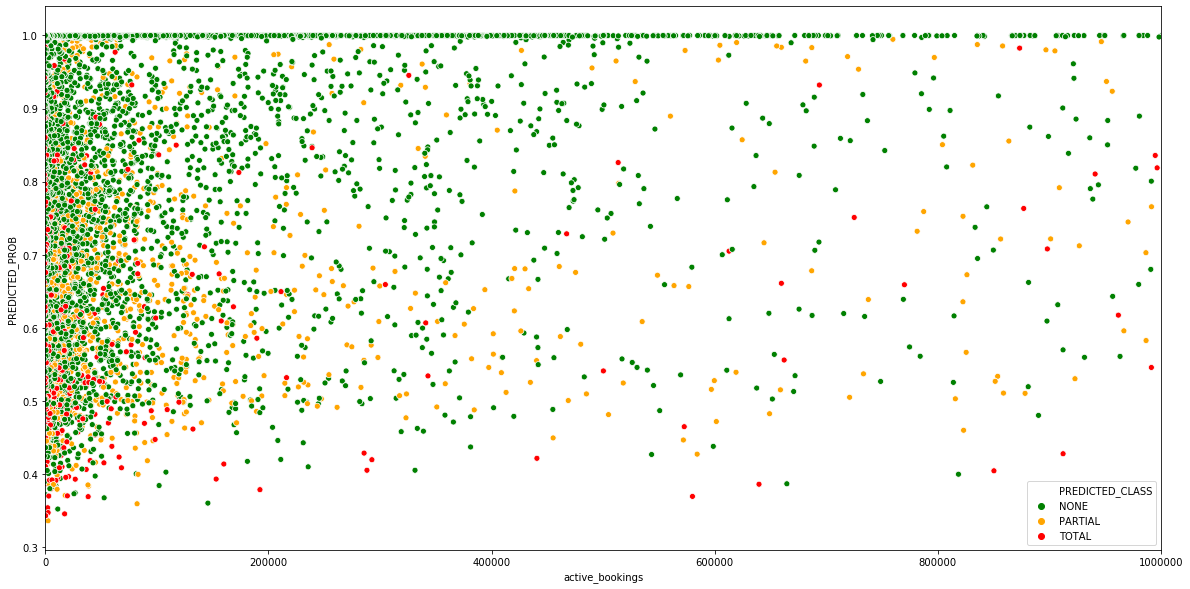

In [196]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ax2 = modeltable_jnl_display.plot.scatter(x='total_bookings',
#                       y='PREDICTED_PROB',
#                       c='species',
#                       colormap='PREDICTED_CLASS')

# fg = sns.FacetGrid(data=modeltable_jnl_display, hue='PREDICTED_CLASS')
# fg.map(plt.scatter, 'total_bookings', 'PREDICTED_PROB').add_legend()

color_dict = dict({0:'green',
                   1:'orange',
                   2:'red'
                  })

color_dict = dict({'NONE':'green',
                   'PARTIAL':'orange',
                   'TOTAL':'red'
                  })


plt.figure(figsize=(20, 10))
plt.xlim(0, 1000000)
g = sns.scatterplot(data=jnl_churn_cust, x='active_bookings', 
                y='PREDICTED_PROB',hue="PREDICTED_CLASS", palette=color_dict, legend='full')




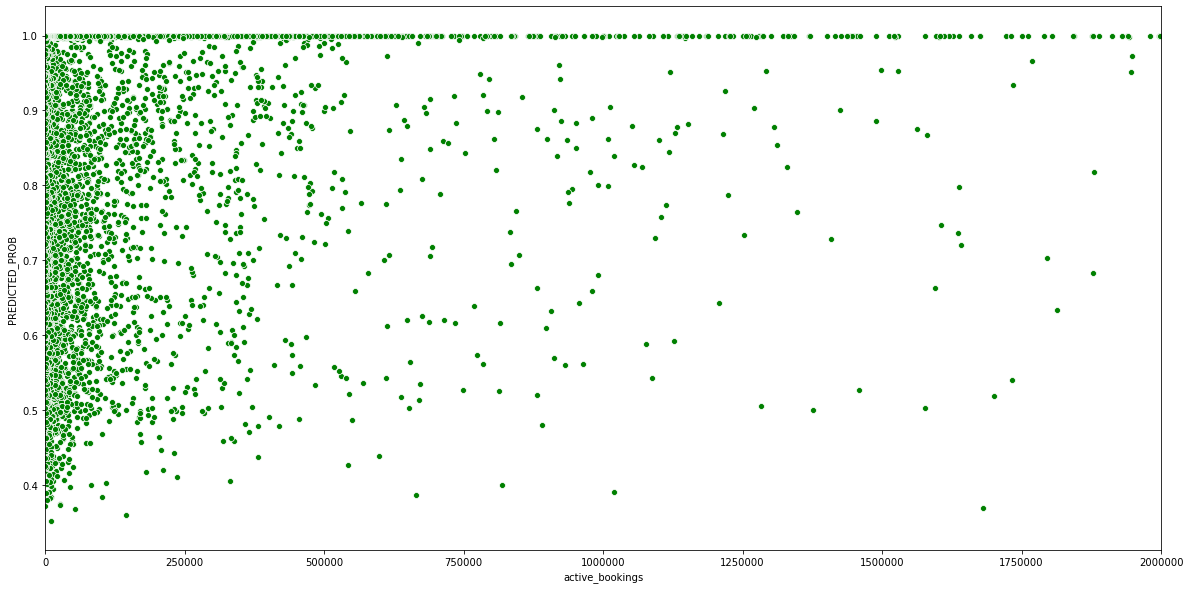

In [197]:
plt.figure(figsize=(20, 10))
plt.xlim(0, 2000000)
sns.scatterplot(data=jnl_churn_cust[jnl_churn_cust.PREDICTED_CLASS.isin(['NONE'])], 
                x='active_bookings', y='PREDICTED_PROB', color='green')

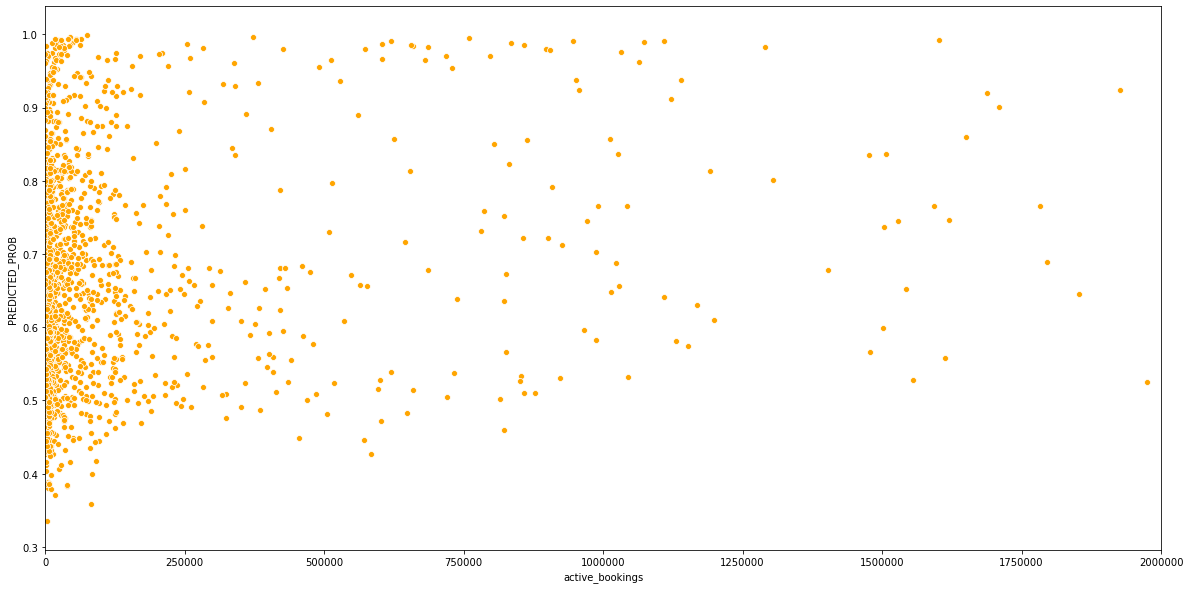

In [198]:
plt.figure(figsize=(20, 10))
plt.xlim(0, 2000000)
sns.scatterplot(data=jnl_churn_cust[jnl_churn_cust.PREDICTED_CLASS.isin(['PARTIAL'])], 
                x='active_bookings', y='PREDICTED_PROB', color='orange')

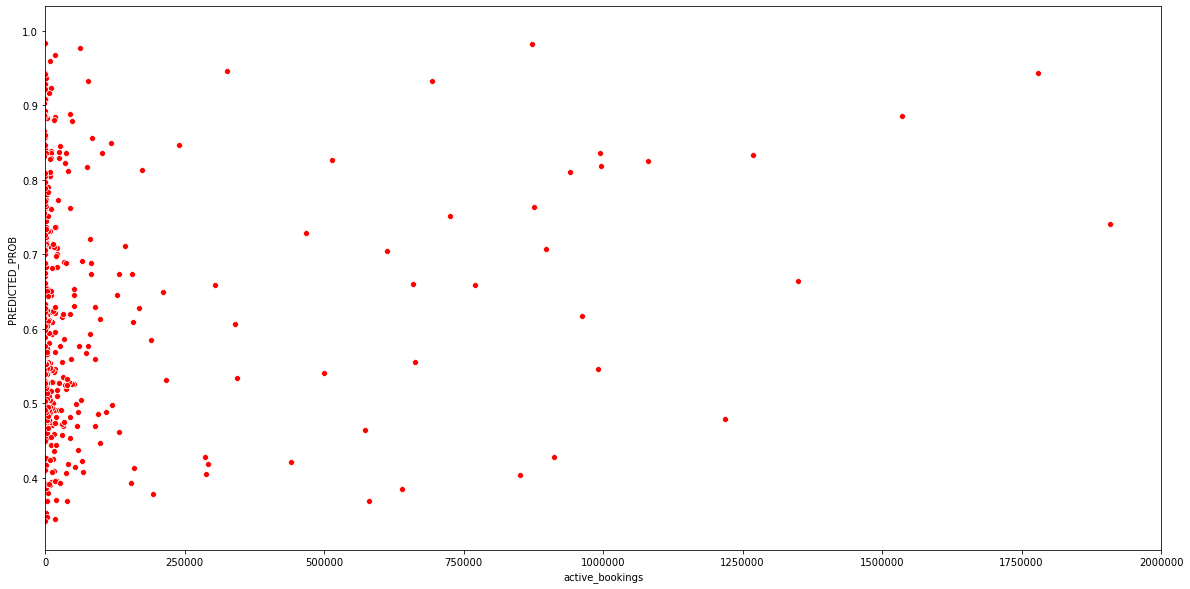

In [199]:
plt.figure(figsize=(20, 10))
plt.xlim(0, 2000000)
sns.scatterplot(data=jnl_churn_cust[jnl_churn_cust.PREDICTED_CLASS == 'TOTAL'], 
                x='active_bookings', y='PREDICTED_PROB', color='red')

In [200]:
jnl_churn_cust['Classification'] = jnl_churn_cust['Classification'].astype('category')

<Figure size 1080x432 with 0 Axes>

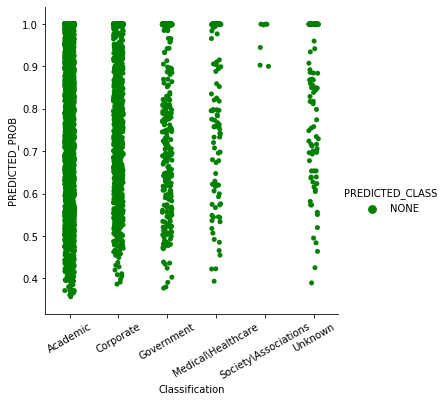

In [459]:
color_dict = dict({'NONE':'green',
                   'PARTIAL':'orange',
                   'TOTAL':'red'
                  })
plt.figure(figsize=(15, 6))
g = sns.catplot(data=jnl_churn_cust[jnl_churn_cust.PREDICTED_CLASS.isin(['NONE'])], 
                x='Classification', y='PREDICTED_PROB', hue='PREDICTED_CLASS', 
               palette=color_dict, legend='full')
g.set_xticklabels(rotation=30)

<Figure size 1080x432 with 0 Axes>

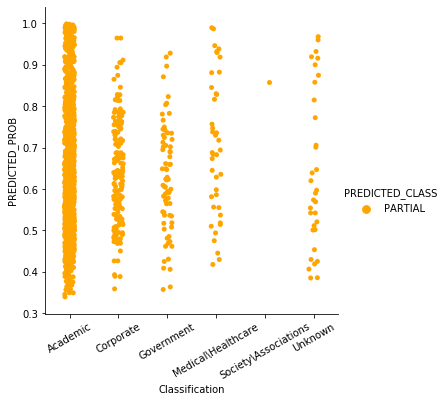

In [460]:
color_dict = dict({'NONE':'green',
                   'PARTIAL':'orange',
                   'TOTAL':'red'
                  })
plt.figure(figsize=(15, 6))
g = sns.catplot(data=jnl_churn_cust[jnl_churn_cust.PREDICTED_CLASS.isin(['PARTIAL'])], 
                x='Classification', y='PREDICTED_PROB', hue='PREDICTED_CLASS', 
               palette=color_dict, legend='full')
g.set_xticklabels(rotation=30)

<Figure size 1080x432 with 0 Axes>

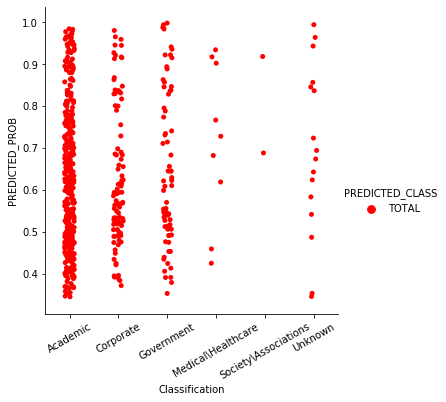

In [461]:
color_dict = dict({'NONE':'green',
                   'PARTIAL':'orange',
                   'TOTAL':'red'
                  })
plt.figure(figsize=(15, 6))
g = sns.catplot(data=jnl_churn_cust[jnl_churn_cust.PREDICTED_CLASS.isin(['TOTAL'])], 
                x='Classification', y='PREDICTED_PROB', hue='PREDICTED_CLASS', 
               palette=color_dict, legend='full')
g.set_xticklabels(rotation=30)

In [221]:
color_dict = dict({'NONE':'green',
                   'PARTIAL':'orange',
                   'TOTAL':'red'
                  })


#plot_df = jnl_churn_cust[jnl_churn_cust['3_yr_usg_change_pct'] < 0]
plot_df = jnl_churn_cust

cust_sum = plot_df.groupby(['PREDICTED_CLASS', 'COUNTRY_CHILD']).agg(
    percent_cust = ('ecrid', 'count')
)


cust_sum.index.values

pd.set_option('display.float_format', lambda x: '%.0f' % x)
pct = cust_sum.groupby(level=0).apply(lambda x: 100* x / float(x.sum()))
pct

pct = pct[pct.percent_cust > 10]

pct


percent_cust
PREDICTED_CLASS COUNTRY_CHILD              
NONE            Japan                    11
                United States            27
PARTIAL         India                    14
                United States            16
TOTAL           Australia                12
                Germany                  11
                India                    12
                United States            19

<ipython-input-540-c3390608eca8>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


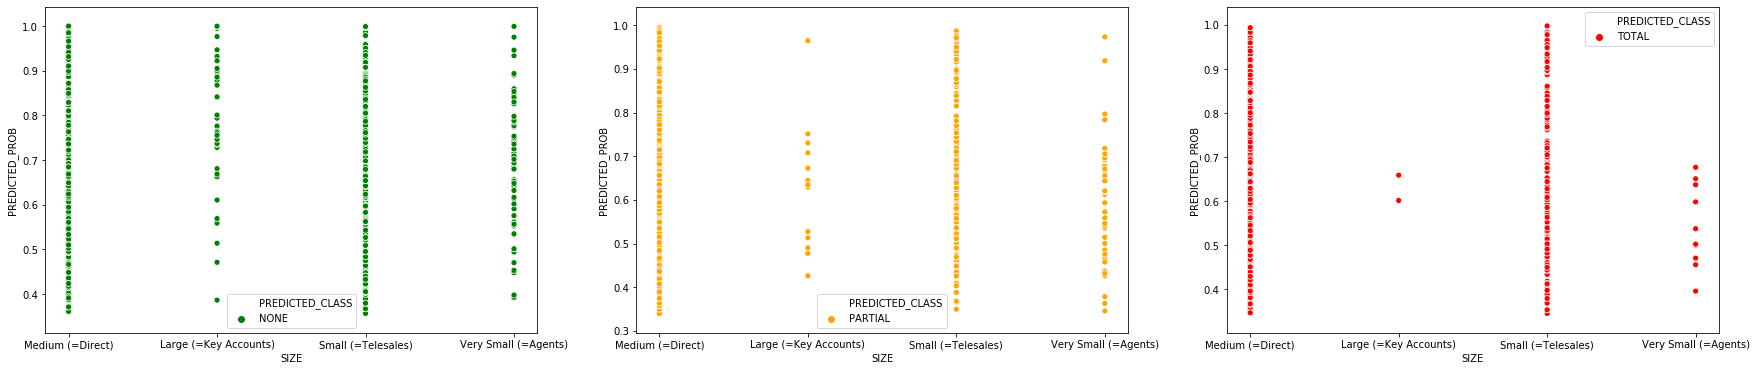

In [540]:

color_dict = dict({'NONE':'green',
                   'PARTIAL':'orange',
                   'TOTAL':'red'
                  })

fig, ax = plt.subplots(1, 3, figsize=(30,6))


sns.scatterplot(data=jnl_churn_cust[jnl_churn_cust.PREDICTED_CLASS == 'NONE'], 
                x='SIZE', y='PREDICTED_PROB', hue='PREDICTED_CLASS', ax=ax[0],
               palette=color_dict, legend='full')


sns.scatterplot(data=jnl_churn_cust[jnl_churn_cust.PREDICTED_CLASS == 'PARTIAL'], 
                x='SIZE', y='PREDICTED_PROB', hue='PREDICTED_CLASS', ax=ax[1],
               palette=color_dict, legend='full')
sns.scatterplot(data=jnl_churn_cust[jnl_churn_cust.PREDICTED_CLASS == 'TOTAL'], 
                x='SIZE', y='PREDICTED_PROB', hue='PREDICTED_CLASS', ax=ax[2],
               palette=color_dict, legend='full')

fig.show()

<Figure size 360x360 with 0 Axes>

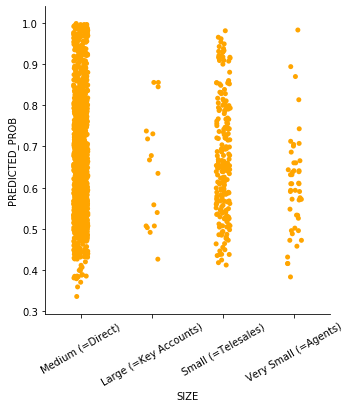

In [228]:
plt.figure(figsize=(5, 5))
#plt.xlim(0, 1000000)
g = sns.catplot(data=jnl_churn_cust[jnl_churn_cust.PREDICTED_CLASS == 'PARTIAL'], 
                x='SIZE', y='PREDICTED_PROB', color='orange')
g.set_xticklabels(rotation=30)

In [464]:
jnl_churn_cust['CONSORTIUM'].value_counts()

NON-CONS      7802
CONSORTIUM      56
Name: CONSORTIUM, dtype: int64

<Figure size 1080x432 with 0 Axes>

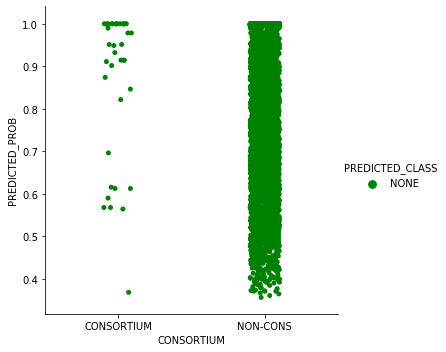

In [465]:
plt.figure(figsize=(15, 6))
sns.catplot(data=jnl_churn_cust[jnl_churn_cust.PREDICTED_CLASS == 'NONE'], 
                x='CONSORTIUM', y='PREDICTED_PROB', hue='PREDICTED_CLASS', palette=color_dict)

<Figure size 1080x432 with 0 Axes>

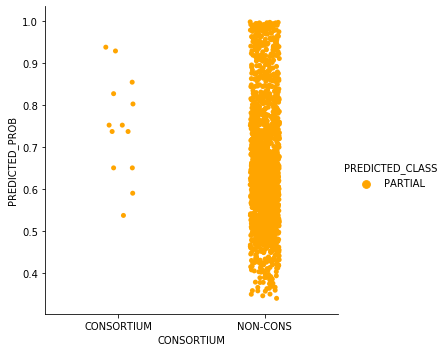

In [466]:
plt.figure(figsize=(15, 6))
#plt.xlim(0, 1000000)
sns.catplot(data=jnl_churn_cust[jnl_churn_cust.PREDICTED_CLASS == 'PARTIAL'], 
                x='CONSORTIUM', y='PREDICTED_PROB', hue='PREDICTED_CLASS', palette=color_dict)

<Figure size 1080x432 with 0 Axes>

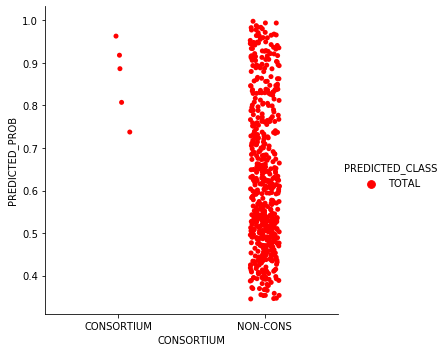

In [467]:
plt.figure(figsize=(15, 6))
#plt.xlim(0, 1000000)
sns.catplot(data=jnl_churn_cust[jnl_churn_cust.PREDICTED_CLASS == 'TOTAL'], 
                x='CONSORTIUM', y='PREDICTED_PROB', hue='PREDICTED_CLASS', palette=color_dict)

In [541]:
jnl_churn_cust.columns

Index(['TYPE', 'total_bookings', 'total_mean_bookings', 'total_num_agrmts',
       'total_num_agrmts_with_parents', 'total_days_since_last_agreement',
       'total_days_since_first_agreement', 'total_length_of_relationship',
       'total_bookings_per_year', 'over_million_year', 'Product Line Level 2',
       'prod_bookings', 'prod_mean_bookings', 'prod_num_agrmts',
       'prod_num_agrmts_with_parents', 'prod_days_since_last_agreement',
       'prod_days_since_first_agreement', 'prod_length_of_relationship',
       'prod_bookings_per_year', 'Classification', 'CHILD_ECR', 'CHILD_NAME',
       'CONSORTIUM', 'COUNTRY_CHILD', 'COUNTRY_PARENT', 'HIERARCHY_TYPE',
       'HIER_LEVEL', 'PARENT_ECR', 'PARENT_NAME', 'num_child', 'max_hier',
       'cust_booking_trend', 'cust_prod_booking_trend', 'jnl_usage_trend',
       '3_yr_mean_usage', '3_yr_usg_change_pct', '3_yr_usg_change',
       'visits_trend', 'visits_3_year_change', 'time_trend',
       'time_3_year_change', 'pageviews_trend', 'page

<Figure size 1440x1440 with 0 Axes>

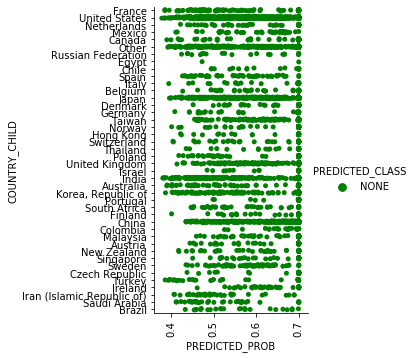

In [554]:
plt.figure(figsize=(20, 20))
g = sns.catplot(data=jnl_churn_cust[jnl_churn_cust.PREDICTED_CLASS == 'NONE'], 
                y='COUNTRY_CHILD', x='PREDICTED_PROB', hue='PREDICTED_CLASS', 
                palette=color_dict)
g.set_xticklabels(rotation=90)

<Figure size 1440x1440 with 0 Axes>

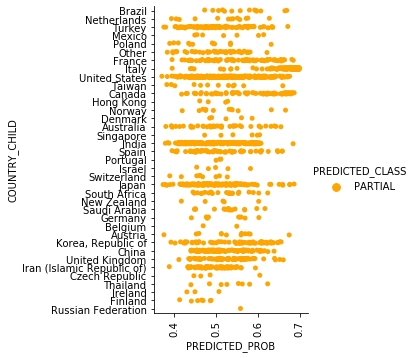

In [555]:
plt.figure(figsize=(20, 20))
g = sns.catplot(data=jnl_churn_cust[jnl_churn_cust.PREDICTED_CLASS == 'PARTIAL'], 
                y='COUNTRY_CHILD', x='PREDICTED_PROB', hue='PREDICTED_CLASS', 
                palette=color_dict)
g.set_xticklabels(rotation=90)

<Figure size 1440x1440 with 0 Axes>

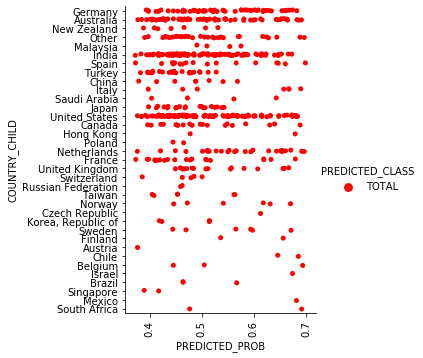

In [553]:
plt.figure(figsize=(20, 20))
g = sns.catplot(data=jnl_churn_cust[jnl_churn_cust.PREDICTED_CLASS == 'TOTAL'], 
                y='COUNTRY_CHILD', x='PREDICTED_PROB', hue='PREDICTED_CLASS', 
                palette=color_dict)
g.set_xticklabels(rotation=90)

In [468]:
jnl_churn_cust.groupby(['CONSORTIUM', 'PREDICTED_CLASS']).agg(prod_bookings=('prod_bookings', sum))

prod_bookings
CONSORTIUM PREDICTED_CLASS               
CONSORTIUM NONE              927546185.91
           PARTIAL           473967992.93
           TOTAL              20350821.28
NON-CONS   NONE             5688245457.92
           PARTIAL          1692203153.91
           TOTAL             201332241.40

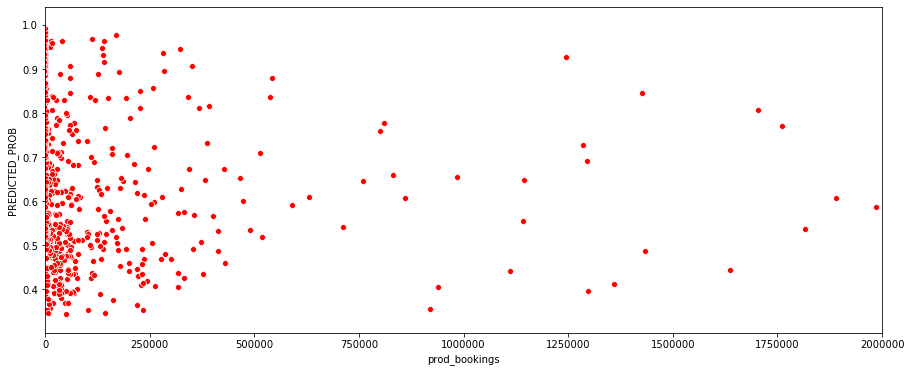

In [469]:
plt.figure(figsize=(15, 6))
plt.xlim(0, 2000000)
sns.scatterplot(data=jnl_churn_cust[jnl_churn_cust.PREDICTED_CLASS == 'TOTAL'], 
                x='active_bookings', y='PREDICTED_PROB', color='red')

<Figure size 1080x432 with 0 Axes>

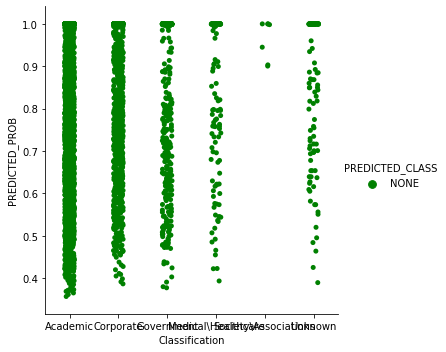

In [470]:
plt.figure(figsize=(15, 6))
sns.catplot(data=jnl_churn_cust[jnl_churn_cust.PREDICTED_CLASS == 'NONE'], 
                x='Classification', y='PREDICTED_PROB', hue='PREDICTED_CLASS',
               palette=color_dict, legend='full')

# FOR SOLUTIONS

In [471]:
# load model from file
sln_model = pickle.load(open("../models/solutions_xgb.pickle.dat", "rb"))

In [497]:
sln_features = sln_model.get_booster().feature_names
sln_features

['prod_num_agrmts',
 'prod_mean_bookings',
 'prod_days_since_last_agreement',
 'prod_days_since_first_agreement',
 'total_mean_bookings',
 'num_activities_Virtual',
 'gerd_churn_year']

In [498]:
modeltable_sln_display = basetable_sln_display.set_index(['SIS Id  (Agreement SIS)', 'Product Line Level 2'])
modeltable_sln_display = modeltable_sln_display[sln_features]

In [499]:
modeltable_sln_display.describe()

,prod_num_agrmts,prod_mean_bookings,prod_days_since_last_agreement,prod_days_since_first_agreement,total_mean_bookings,num_activities_Virtual,gerd_churn_year
count,13526.00,13526.00,13526.00,13526.00,13526.00,13526.00,13526.00
mean,4.97,25140.47,467.39,1540.11,18693.90,12.36,120489.75
std,2.57,55546.42,416.02,594.08,39678.00,16.77,146743.70
min,1.00,-58317.03,-273.00,154.00,-58317.03,0.00,116.67
25%,3.00,3790.79,123.00,1157.00,4759.80,2.00,21133.17
50%,5.00,14933.34,427.00,1615.00,11137.63,6.00,55565.74
75%,6.00,28762.21,672.00,1888.00,20473.80,16.00,160397.16
max,34.00,1826427.00,2163.00,3775.00,1826427.00,328.00,522878.63


In [500]:
# nothing to encode as there are not categorical features
modeltable, le_dict = encode_labels(modeltable_sln_display.copy(), [])

In [501]:
pd.set_option("display.max_rows", 90)
get_data_frame_summary(modeltable_sln_display)

,index,unique_values,unique_counts,na_counts,data_type,percent_missing
0,prod_num_agrmts,"[[14.0, 10.0, 20.0, 9.0, 18.0, 3.0, 6.0, 16.0,...",28,0,int64,0.00
1,prod_mean_bookings,"[[1176079.101935484, 265771.8390909091, 48380....",7175,0,float64,0.00
2,prod_days_since_last_agreement,"[[62.0, 792.0, 1523.0, 427.0, 123.0, 641.0, 21...",632,0,int64,0.00
3,prod_days_since_first_agreement,"[[1888.0, 792.0, 2618.0, 427.0, 1523.0, 2253.0...",795,0,int64,0.00
4,total_mean_bookings,"[[259393.92563868687, 8854.55736842105, 0.0, 2...",4652,0,float64,0.00
5,num_activities_Virtual,"[[103.0, 71.0, 4.0, 34.0, 8.0, 7.0, 10.0, 6.0,...",95,0,float64,0.00
6,gerd_churn_year,"[[38969.04622, 11196.00427, 24841.385769999997...",59,0,float64,0.00


In [502]:
get_data_frame_summary(modeltable)

,index,unique_values,unique_counts,na_counts,data_type,percent_missing
0,prod_num_agrmts,"[[14.0, 10.0, 20.0, 9.0, 18.0, 3.0, 6.0, 16.0,...",28,0,int64,0.00
1,prod_mean_bookings,"[[1176079.101935484, 265771.8390909091, 48380....",7175,0,float64,0.00
2,prod_days_since_last_agreement,"[[62.0, 792.0, 1523.0, 427.0, 123.0, 641.0, 21...",632,0,int64,0.00
3,prod_days_since_first_agreement,"[[1888.0, 792.0, 2618.0, 427.0, 1523.0, 2253.0...",795,0,int64,0.00
4,total_mean_bookings,"[[259393.92563868687, 8854.55736842105, 0.0, 2...",4652,0,float64,0.00
5,num_activities_Virtual,"[[103.0, 71.0, 4.0, 34.0, 8.0, 7.0, 10.0, 6.0,...",95,0,float64,0.00
6,gerd_churn_year,"[[38969.04622, 11196.00427, 24841.385769999997...",59,0,float64,0.00


In [503]:
pred = sln_model.predict(modeltable)

In [504]:
proba = sln_model.predict_proba(modeltable)

In [505]:
pd.Series(pred).value_counts()

0    10029
1     2291
2     1206
dtype: int64

In [506]:
proba

array([[9.9310911e-01, 6.8521909e-03, 3.8648202e-05],
       [9.9310911e-01, 6.8521909e-03, 3.8648202e-05],
       [9.7362614e-01, 2.6195852e-02, 1.7805920e-04],
       ...,
       [2.3984894e-02, 1.6498991e-03, 9.7436517e-01],
       [9.7669774e-01, 2.0782871e-02, 2.5193978e-03],
       [9.7669774e-01, 2.0782871e-02, 2.5193978e-03]], dtype=float32)

In [507]:
proba.max(axis=1)

array([0.9931091 , 0.9931091 , 0.97362614, ..., 0.9743652 , 0.97669774,
       0.97669774], dtype=float32)

In [508]:
pred

array([0, 0, 0, ..., 2, 0, 0])

In [509]:
modeltable_sln_display['PREDICTED_CLASS'] = pred
modeltable_sln_display['PREDICTED_PROB'] = proba.max(axis=1)

In [510]:
modeltable_sln_display['PREDICTED_CLASS'].replace({0: 'NONE', 1: 'PARTIAL', 2:'TOTAL'}, inplace=True)


# modeltable_jnl_display[modeltable_jnl_display['PREDICTED_CLASS'].isin(['PARTIAL', 'TOTAL'])][['total_bookings', 
#                                                                                               'over_million_year', 
#                         'Classification', 'SIZE', 'TIER', 'PREDICTED_CLASS', 'PREDICTED_PROB']].head(20)

modeltable_sln_display

prod_num_agrmts  prod_mean_bookings  prod_days_since_last_agreement  prod_days_since_first_agreement  total_mean_bookings  num_activities_Virtual  gerd_churn_year PREDICTED_CLASS  PREDICTED_PROB
SIS Id  (Agreement SIS) Product Line Level 2                                                                                                                                                                                                    
ECR-310775              SCOPUS                             14          1176079.10                              62                             1888            259393.93                  103.00         38969.05            NONE            0.99
                        SCOPUS                             14          1176079.10                              62                             1888            259393.93                  103.00         38969.05            NONE            0.99
                        EV                                 10           265771.84                              62                             1888            259393.93                  103.00         38969.05            NONE            0.97
                        EV                                 10           265771.84                              62                             1888            259393.93                  103.00         38969.05            NONE            0.97
                        eBooks                             20            48380.20                              62                             1888            259393.93                  103.00         38969.05            NONE            0.94
...                                                       ...                 ...                             ...                              ...                  ...                     ...              ...             ...             ...
ECR-916                 eBooks                              3             3054.55                              62                              792             -1227.95                    1.00        160397.16            NONE            1.00
ECR-486533              embase                              2            -8614.35                             462                              827             -8614.35                    8.00         45140.85           TOTAL            0.97
                        embase                              2            -8614.35                             462                              827             -8614.35                    8.00         45140.85           TOTAL            0.97
ECR-2844                eBooks                              6             1342.12                              62                             1523             -9449.87                    2.00        160397.16            NONE            0.98
                        eBooks                              6             1342.12                              62                             1523             -9449.87                    2.00        160397.16            NONE            0.98

[13526 rows x 9 columns]

In [511]:
modeltable_sln_display = modeltable_sln_display.reset_index()

In [512]:
modeltable_sln_display = modeltable_sln_display[['SIS Id  (Agreement SIS)', 'Product Line Level 2', 'PREDICTED_CLASS', 'PREDICTED_PROB']]

sln_churn_cust = pd.merge(basetable_sln_display, 
                          modeltable_sln_display,
                         on=['SIS Id  (Agreement SIS)', 'Product Line Level 2'])

In [513]:
try:
    ech = ech.drop(['Classification'], axis=1)
except:
    print('classification already removed')

classificatiojn already removed


In [514]:
sln_churn_cust = pd.merge(sln_churn_cust, ech, left_on='SIS Id  (Agreement SIS)', right_on='ecrid', how='inner')

In [515]:
print(f'Unique Customers {len(sln_churn_cust["SIS Id  (Agreement SIS)"].unique())}')
print(f'Unique Customers {len(sln_churn_cust["Product Line Level 2"].unique())}')

print(f'Unique Customers {len(modeltable_sln_display["SIS Id  (Agreement SIS)"].unique())}')
print(f'Unique Customers {len(modeltable_sln_display["Product Line Level 2"].unique())}')

print(f'Unique Customers {len(basetable_sln_display["SIS Id  (Agreement SIS)"].unique())}')
print(f'Unique Customers {len(basetable_sln_display["Product Line Level 2"].unique())}')

Unique Customers 5100
Unique Customers 22
Unique Customers 5100
Unique Customers 22
Unique Customers 5100
Unique Customers 22


<b> Keep one row per customer product combination </b>

In [516]:
#attach active value
sln_churn_cust = pd.merge(sln_churn_cust, active_value, on=["SIS Id  (Agreement SIS)", "Product Line Level 2"], how='inner')

In [517]:
print(sln_churn_cust.shape)
sln_churn_cust = sln_churn_cust.drop_duplicates(["SIS Id  (Agreement SIS)", "Product Line Level 2"])
print(sln_churn_cust.shape)

(24076, 89)
(8251, 89)


In [518]:
# dropn unnecessary columns
sln_churn_cust = sln_churn_cust.drop(['SIS Id  (Agreement SIS)'], axis=1)

In [519]:
sln_churn_cust.to_csv('../model_output/solutions_churn_result.csv', index=False)

In [520]:
modeltable_sln_display['PREDICTED_CLASS'] = pred
modeltable_sln_display['PREDICTED_PROB'] = proba.max(axis=1)

In [521]:
modeltable_sln_display.columns

Index(['SIS Id  (Agreement SIS)', 'Product Line Level 2', 'PREDICTED_CLASS',
       'PREDICTED_PROB'],
      dtype='object')

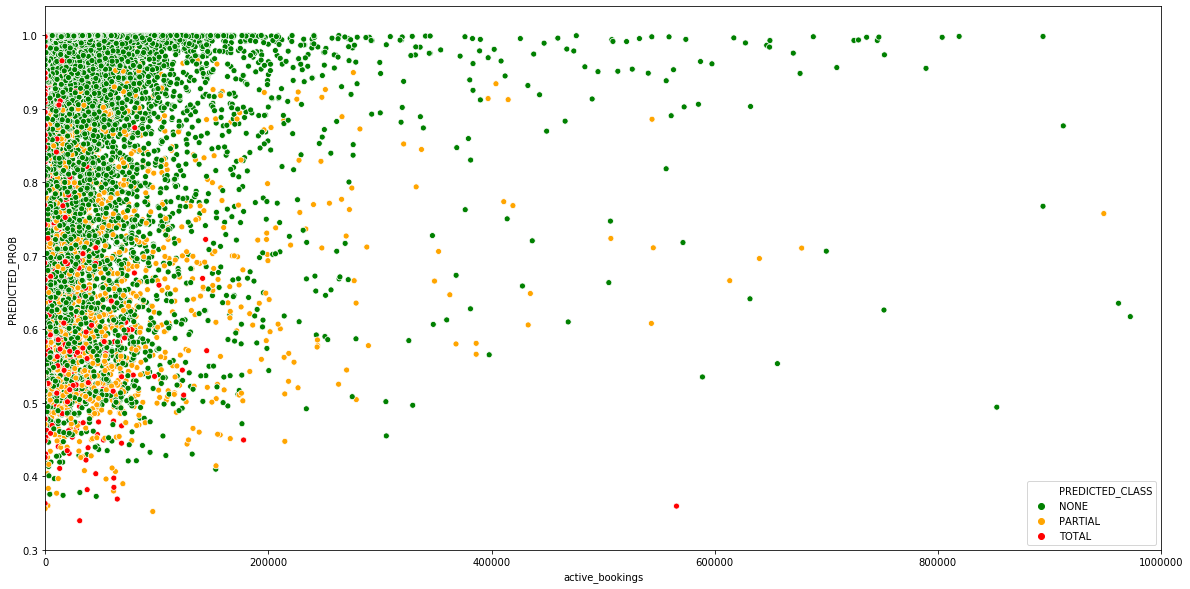

In [522]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ax2 = modeltable_jnl_display.plot.scatter(x='total_bookings',
#                       y='PREDICTED_PROB',
#                       c='species',
#                       colormap='PREDICTED_CLASS')

# fg = sns.FacetGrid(data=modeltable_jnl_display, hue='PREDICTED_CLASS')
# fg.map(plt.scatter, 'total_bookings', 'PREDICTED_PROB').add_legend()

color_dict = dict({0:'green',
                   1:'orange',
                   2:'red'
                  })

color_dict = dict({'NONE':'green',
                   'PARTIAL':'orange',
                   'TOTAL':'red'
                  })


plt.figure(figsize=(20, 10))
plt.xlim(0, 1000000)
g = sns.scatterplot(data=sln_churn_cust, x='active_bookings', 
                y='PREDICTED_PROB',hue="PREDICTED_CLASS", palette=color_dict, legend='full')




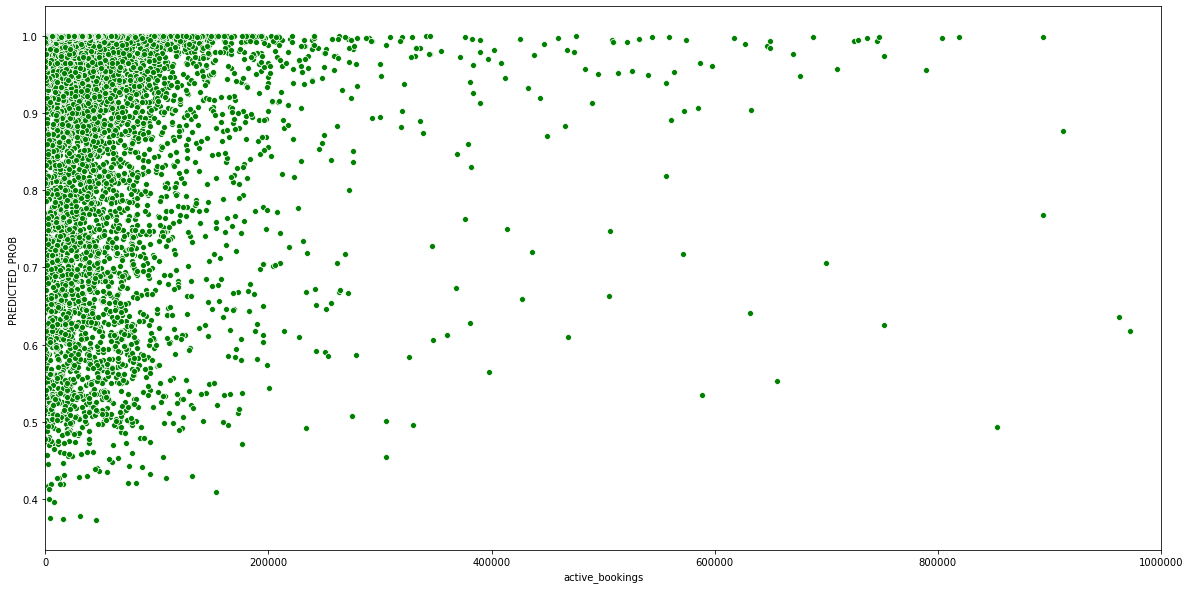

In [523]:
plt.figure(figsize=(20, 10))
plt.xlim(0, 1000000)
sns.scatterplot(data=sln_churn_cust[sln_churn_cust.PREDICTED_CLASS.isin(['NONE'])], 
                x='active_bookings', y='PREDICTED_PROB', color='green')

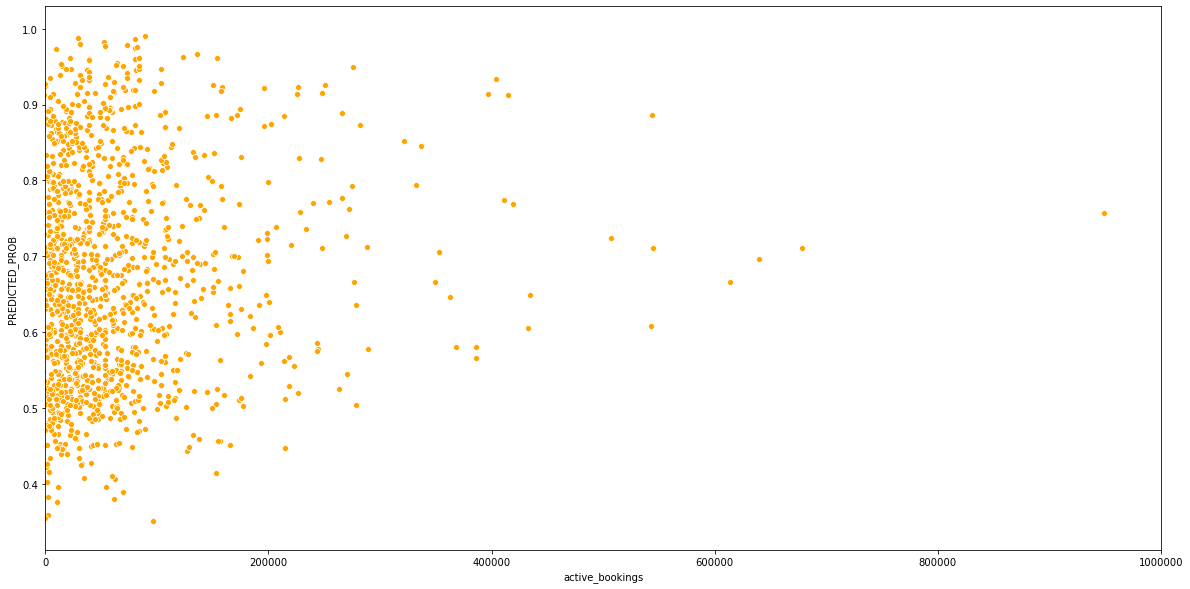

In [524]:
plt.figure(figsize=(20, 10))
plt.xlim(0, 1000000)
sns.scatterplot(data=sln_churn_cust[sln_churn_cust.PREDICTED_CLASS.isin(['PARTIAL'])], 
                x='active_bookings', y='PREDICTED_PROB', color='orange')

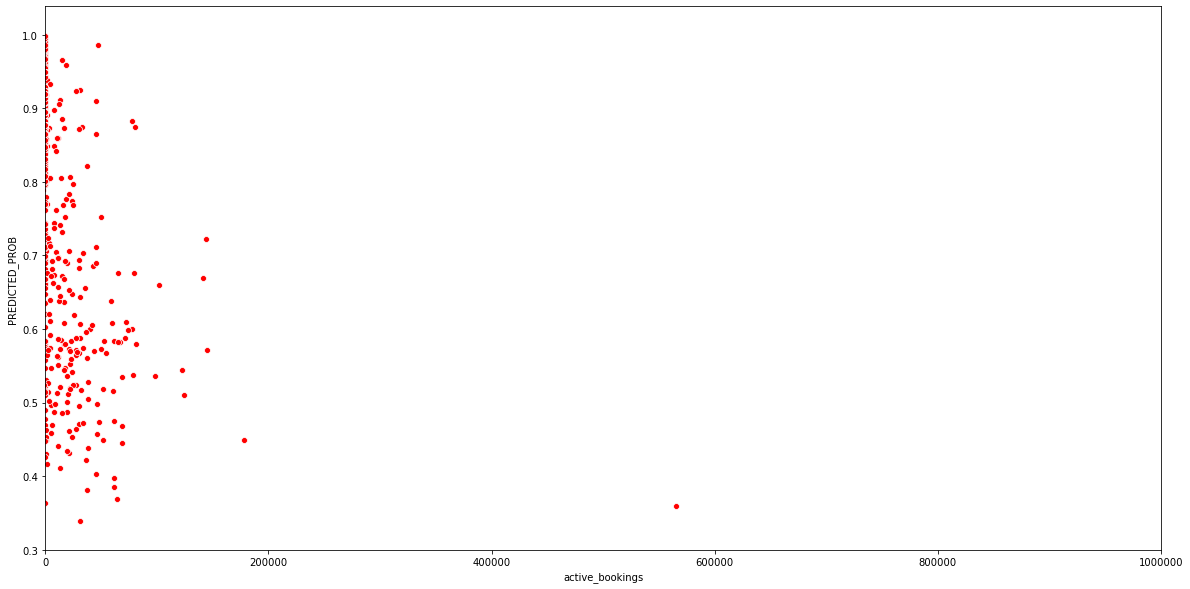

In [525]:
plt.figure(figsize=(20, 10))
plt.xlim(0, 1000000)
sns.scatterplot(data=sln_churn_cust[sln_churn_cust.PREDICTED_CLASS == 'TOTAL'], 
                x='active_bookings', y='PREDICTED_PROB', color='red')

<Figure size 1080x432 with 0 Axes>

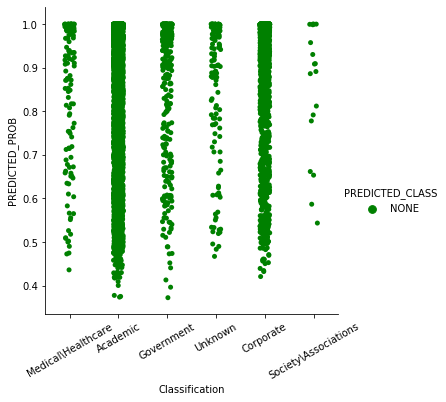

In [526]:
color_dict = dict({'NONE':'green',
                   'PARTIAL':'orange',
                   'TOTAL':'red'
                  })
plt.figure(figsize=(15, 6))
g = sns.catplot(data=sln_churn_cust[sln_churn_cust.PREDICTED_CLASS.isin(['NONE'])], 
                x='Classification', y='PREDICTED_PROB', hue='PREDICTED_CLASS', 
               palette=color_dict, legend='full')
g.set_xticklabels(rotation=30)

<Figure size 1080x432 with 0 Axes>

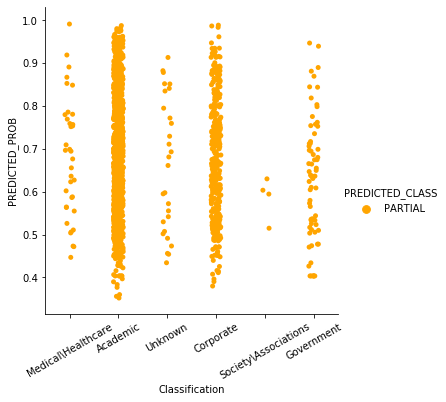

In [527]:
color_dict = dict({'NONE':'green',
                   'PARTIAL':'orange',
                   'TOTAL':'red'
                  })
plt.figure(figsize=(15, 6))
g = sns.catplot(data=sln_churn_cust[sln_churn_cust.PREDICTED_CLASS.isin(['PARTIAL'])], 
                x='Classification', y='PREDICTED_PROB', hue='PREDICTED_CLASS', 
               palette=color_dict, legend='full')
g.set_xticklabels(rotation=30)

<Figure size 1080x432 with 0 Axes>

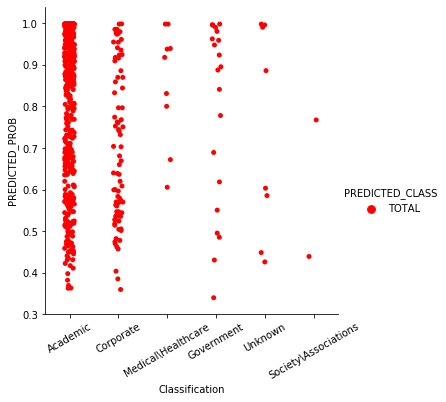

In [528]:
color_dict = dict({'NONE':'green',
                   'PARTIAL':'orange',
                   'TOTAL':'red'
                  })
plt.figure(figsize=(15, 6))
g = sns.catplot(data=sln_churn_cust[sln_churn_cust.PREDICTED_CLASS.isin(['TOTAL'])], 
                x='Classification', y='PREDICTED_PROB', hue='PREDICTED_CLASS', 
               palette=color_dict, legend='full')
g.set_xticklabels(rotation=30)

<ipython-input-529-dd44e0325918>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


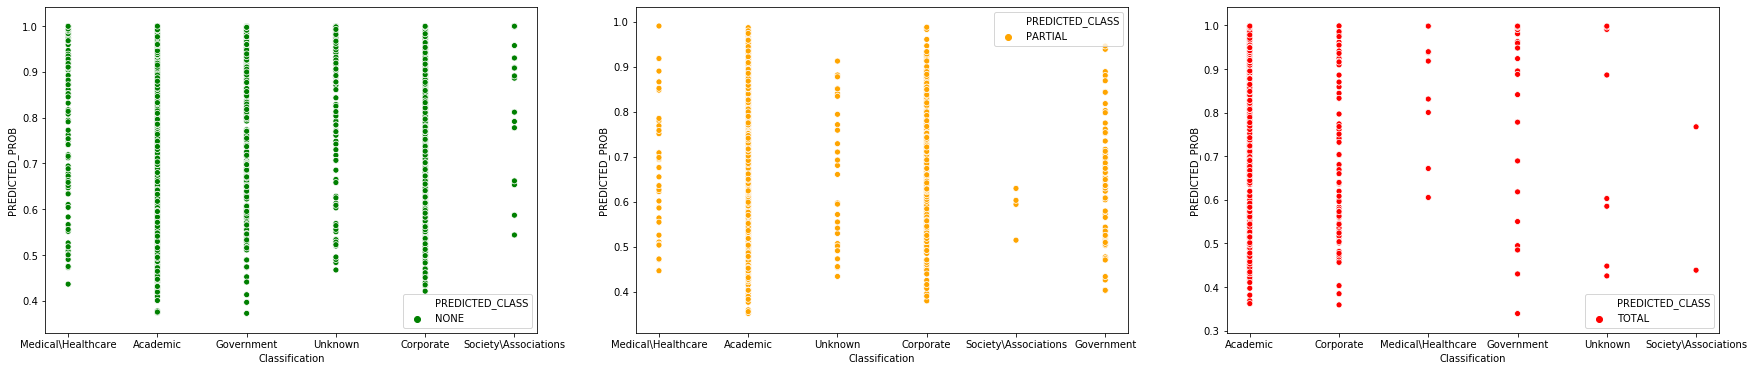

In [529]:

color_dict = dict({'NONE':'green',
                   'PARTIAL':'orange',
                   'TOTAL':'red'
                  })

fig, ax = plt.subplots(1, 3, figsize=(30,6))


sns.scatterplot(data=sln_churn_cust[sln_churn_cust.PREDICTED_CLASS == 'NONE'], 
                x='Classification', y='PREDICTED_PROB', hue='PREDICTED_CLASS', ax=ax[0],
               palette=color_dict, legend='full')


sns.scatterplot(data=sln_churn_cust[sln_churn_cust.PREDICTED_CLASS == 'PARTIAL'], 
                x='Classification', y='PREDICTED_PROB', hue='PREDICTED_CLASS', ax=ax[1],
               palette=color_dict, legend='full')
sns.scatterplot(data=sln_churn_cust[sln_churn_cust.PREDICTED_CLASS == 'TOTAL'], 
                x='Classification', y='PREDICTED_PROB', hue='PREDICTED_CLASS', ax=ax[2],
               palette=color_dict, legend='full')

fig.show()

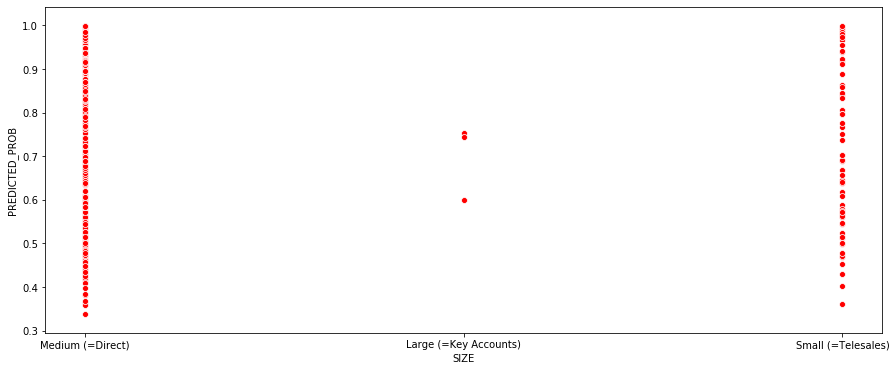

In [530]:
plt.figure(figsize=(15, 6))
#plt.xlim(0, 1000000)
sns.scatterplot(data=sln_churn_cust[sln_churn_cust.PREDICTED_CLASS == 'TOTAL'], 
                x='SIZE', y='PREDICTED_PROB', color='red')

In [531]:
sln_churn_cust['CONSORTIUM'].value_counts()

NON-CONS      8179
CONSORTIUM      72
Name: CONSORTIUM, dtype: int64

<Figure size 1080x432 with 0 Axes>

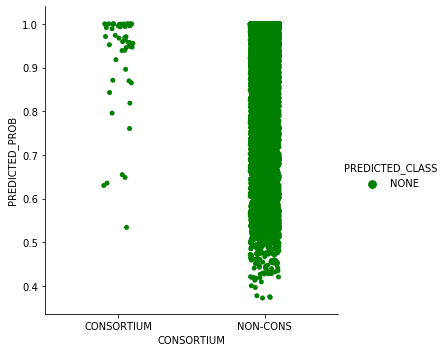

In [532]:
plt.figure(figsize=(15, 6))
sns.catplot(data=sln_churn_cust[sln_churn_cust.PREDICTED_CLASS == 'NONE'], 
                x='CONSORTIUM', y='PREDICTED_PROB', hue='PREDICTED_CLASS', palette=color_dict)

<Figure size 1080x432 with 0 Axes>

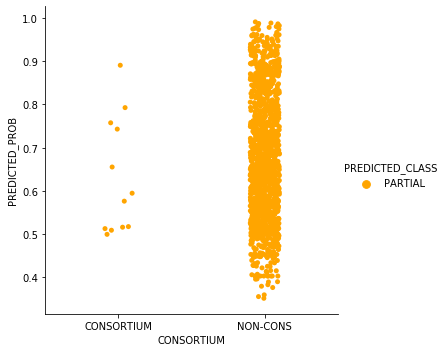

In [533]:
plt.figure(figsize=(15, 6))
#plt.xlim(0, 1000000)
sns.catplot(data=sln_churn_cust[sln_churn_cust.PREDICTED_CLASS == 'PARTIAL'], 
                x='CONSORTIUM', y='PREDICTED_PROB', hue='PREDICTED_CLASS', palette=color_dict)

<Figure size 1080x432 with 0 Axes>

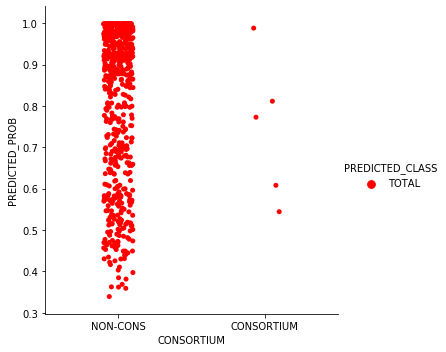

In [534]:
plt.figure(figsize=(15, 6))
#plt.xlim(0, 1000000)
sns.catplot(data=sln_churn_cust[sln_churn_cust.PREDICTED_CLASS == 'TOTAL'], 
                x='CONSORTIUM', y='PREDICTED_PROB', hue='PREDICTED_CLASS', palette=color_dict)

In [535]:
sln_churn_cust.groupby(['CONSORTIUM', 'PREDICTED_CLASS']).agg(prod_bookings=('prod_bookings', sum))

prod_bookings
CONSORTIUM PREDICTED_CLASS               
CONSORTIUM NONE              120155379.40
           PARTIAL            14146678.09
           TOTAL                629155.96
NON-CONS   NONE             1353217022.44
           PARTIAL           338629524.51
           TOTAL              16474711.46

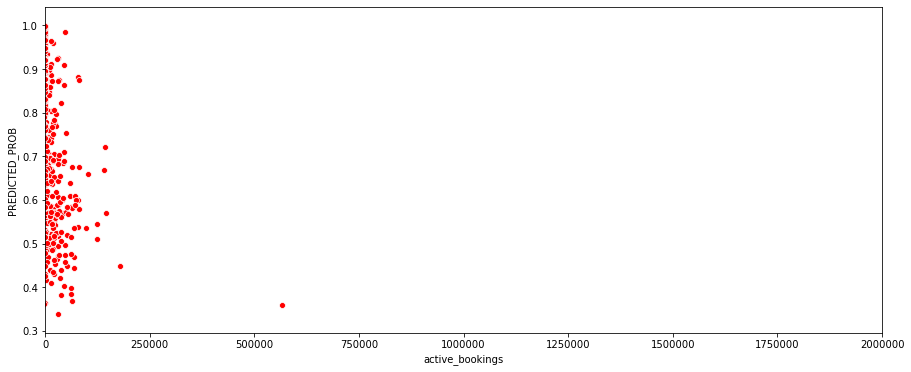

In [536]:
plt.figure(figsize=(15, 6))
plt.xlim(0, 2000000)
sns.scatterplot(data=sln_churn_cust[sln_churn_cust.PREDICTED_CLASS == 'TOTAL'], 
                x='active_bookings', y='PREDICTED_PROB', color='red')

<Figure size 1080x432 with 0 Axes>

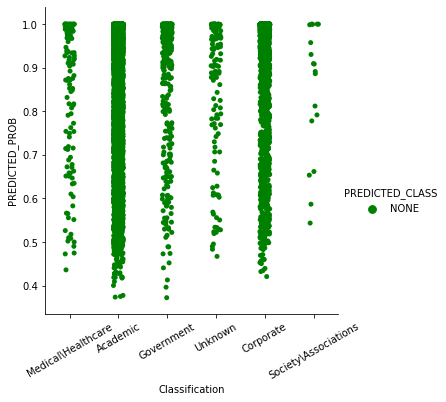

In [537]:
plt.figure(figsize=(15, 6))
g=sns.catplot(data=sln_churn_cust[sln_churn_cust.PREDICTED_CLASS == 'NONE'], 
                x='Classification', y='PREDICTED_PROB', hue='PREDICTED_CLASS',
               palette=color_dict, legend='full')
g.set_xticklabels(rotation=30)

<Figure size 1080x432 with 0 Axes>

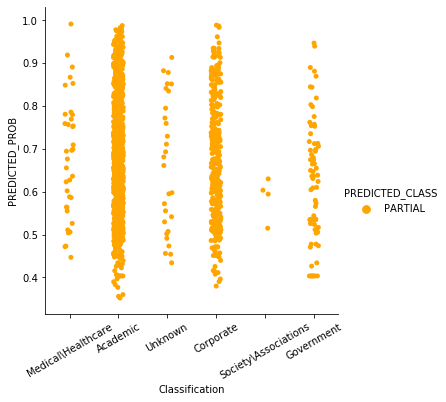

In [538]:
plt.figure(figsize=(15, 6))
g=sns.catplot(data=sln_churn_cust[sln_churn_cust.PREDICTED_CLASS == 'PARTIAL'], 
                x='Classification', y='PREDICTED_PROB', hue='PREDICTED_CLASS',
               palette=color_dict, legend='full')
g.set_xticklabels(rotation=30)

<Figure size 1080x432 with 0 Axes>

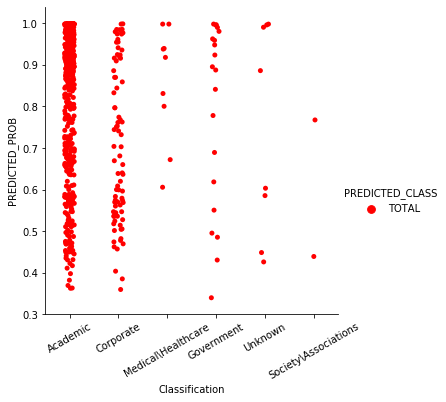

In [539]:
plt.figure(figsize=(15, 6))
g=sns.catplot(data=sln_churn_cust[sln_churn_cust.PREDICTED_CLASS == 'TOTAL'], 
                x='Classification', y='PREDICTED_PROB', hue='PREDICTED_CLASS',
               palette=color_dict, legend='full')
g.set_xticklabels(rotation=30)